## DEX US EU

In [93]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from rw_discrete_model import (
    discretise_Wt,
    simulate_multiple_walks,
    forecast_from_multiple_walks,
    plot_multiple_paths_vs_history
)
from rmse import (
    evaluate_rmse_mae_per_path
)
from rw_continuos_drift_model import (
    simulate_rw_with_drift_paths_and_plot,
    evaluate_simulations
)
from arima_model import (
    simulate_paths_and_plot,
    evaluate_simulations
)
from utils_summary import (
    append_result
)

# Read the CSV file from the preprocessing folder
train_df = pd.read_csv('../2. preprocesing/train_df_dexuseu.csv', index_col=0, parse_dates=True)

# Show the first rows
train_df.head()


rate  rate_interpolated  log_rate      diff        Wt
date                                                               
2015-01-05  1.1918             1.1918  0.175465 -0.008106 -0.008049
2015-01-06  1.1936             1.1936  0.176974  0.001509  0.001566
2015-01-07  1.1820             1.1820  0.167208 -0.009766 -0.009709
2015-01-08  1.1811             1.1811  0.166446 -0.000762 -0.000705
2015-01-09  1.1830             1.1830  0.168054  0.001607  0.001665

### Discrete Random Walk

In [95]:
# model:
# X_t - X_{t-1} = mu + W_t

# X_t = X_0 + mu*t + sum(W_t)

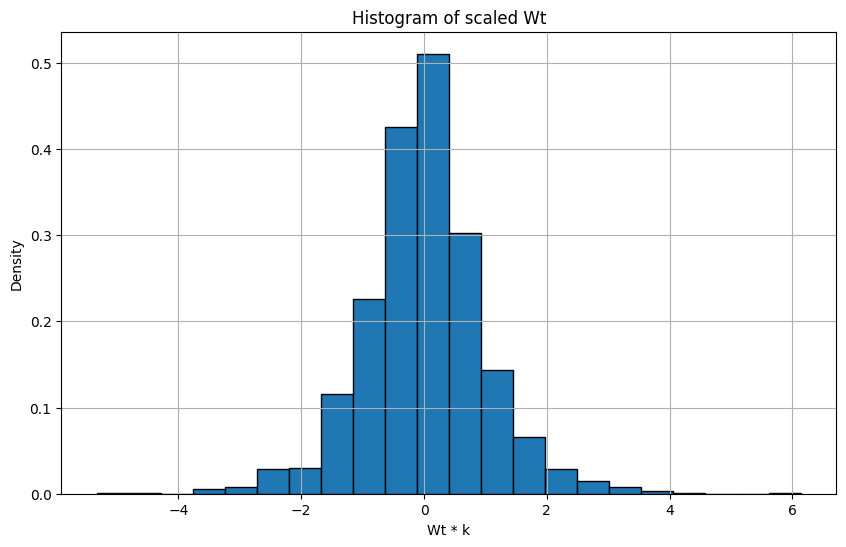

count    2085.000000
mean        0.000001
std         0.004929
min        -0.026667
25%        -0.002622
50%        -0.000034
75%         0.002716
max         0.030700
Name: Wt, dtype: float64


In [96]:
# Set k value
k = 200
df= train_df.copy()
df['scaled_Wt'] = df['Wt'] * k
# basic histogram of the scaled Wt
plt.figure(figsize=(10,6))
plt.hist(df['scaled_Wt'], bins=22, edgecolor='black', density=True)
plt.title('Histogram of scaled Wt')
plt.xlabel('Wt * k')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# statistics of the original Wt
print(df['Wt'].describe())

Empirical probabilities:
P(-1) = 0.2633, P(0) = 0.4719, P(+1) = 0.2647


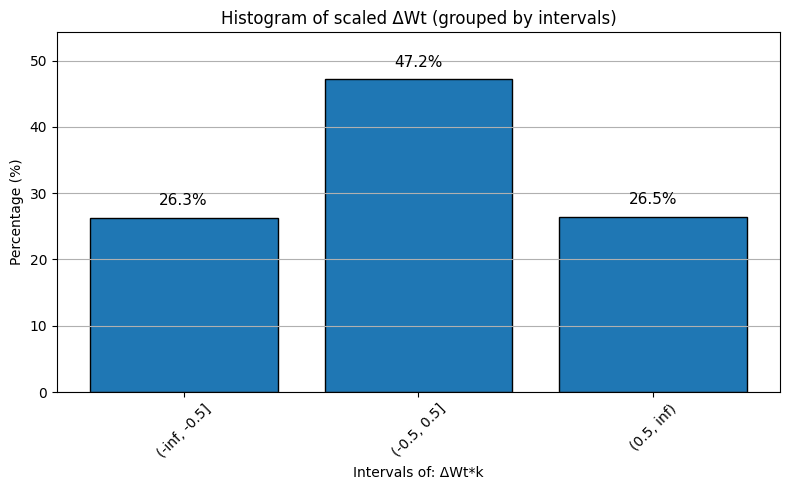

rate  rate_interpolated  log_rate      diff        Wt  \
date                                                                  
2015-01-05  1.1918             1.1918  0.175465 -0.008106 -0.008049   
2015-01-06  1.1936             1.1936  0.176974  0.001509  0.001566   
2015-01-07  1.1820             1.1820  0.167208 -0.009766 -0.009709   
2015-01-08  1.1811             1.1811  0.166446 -0.000762 -0.000705   
2015-01-09  1.1830             1.1830  0.168054  0.001607  0.001665   

            scaled_Wt  e_t scaled_Wt_bin  
date                                      
2015-01-05  -1.609765   -1  (-inf, -0.5]  
2015-01-06   0.313273    0   (-0.5, 0.5]  
2015-01-07  -1.941770   -1  (-inf, -0.5]  
2015-01-08  -0.140906    0   (-0.5, 0.5]  
2015-01-09   0.332912    0   (-0.5, 0.5]

In [97]:
# ----------------------------------------
# with DEXUSEU training data
# ----------------------------------------

# Read the CSV file from the preprocessing folder
train_df = pd.read_csv('../2. preprocesing/train_df_dexuseu.csv', index_col=0, parse_dates=True)
# Step 1: Discretise Wt and get probabilities
train_df_dexuseu, p_dict = discretise_Wt(train_df, k=k,bins=(-0.5, 0.5), labels=(-1, 0, 1), plot=True)

train_df_dexuseu.head(5)

In [98]:
# Manual assigning of probabilities for the example
# p_dict = {-1: 0.27055, 0: 0.4589, 1: 0.27055}
# p_dict = {-1: 0.102, 0: 0.796, 1: 0.102} # k=90 Expected RMSE (%): 2.32
# p_dict = {-1: 0.125, 0: 0.75, 1: 0.125} # k=100 Expected RMSE (%): 2.31
# p_dict = {-1: 0.143, 0: 0.714, 1: 0.143} # k=110 Expected RMSE (%): 2.27
# p_dict = {-1: 0.16, 0: 0.68, 1: 0.16} # k=120 Expected RMSE (%): 2.24
# p_dict = {-1: 0.18, 0: 0.64, 1: 0.18} # k=130 Expected RMSE (%): 2.21
# p_dict = {-1: 0.1925, 0: 0.615, 1: 0.1925} # k=140 Expected RMSE (%): 2.17, 4.41
p_dict = {-1: 0.264, 0: 0.472, 1: 0.264} # k=200 Expected RMSE (%): 1.95, 3.8 

# trend estimation (preproccessing)
# estimated_mu = -0.000004  # this must be your actual drift!
estimated_mu = -0.000057  #  df['log_rate'].diff().mean()

# df for testing
df_test = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)

# Summary DataFrame
summary = pd.DataFrame()

#### Forecasting dicrete RW

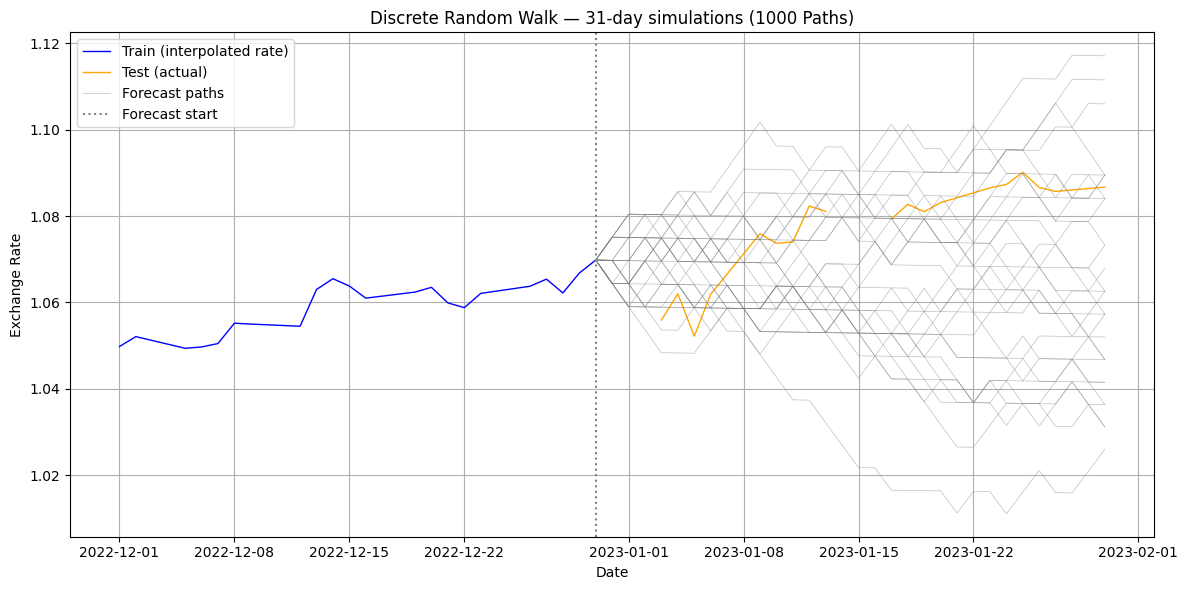

Expected RMSE (%): 1.95
Expected MAE (%): 1.71


In [99]:
# Discrete RW forecasting and evaluation
model_name="Discrete Random Walk"
horizon="1M"
steps=31

# Simulate discrete random walks
walks = simulate_multiple_walks(
    p_dict=p_dict,
    horizon=steps,      
    n_paths=1000,
    seed=42
)

# Forecast from multiple walks
df_paths = forecast_from_multiple_walks(
    train_df=train_df_dexuseu, # historical data
    walks=walks,    # the simulated paths
    k=k,            # the same K value
    mu=estimated_mu # this must be your actual drift!
)

# Plot the paths against the historical data
plot_multiple_paths_vs_history(
    train_df=train_df_dexuseu,
    df_paths=df_paths,
    df_test=df_test,
    rate_col='rate',
    n_show=30
)

# Evaluation 
df_paths.index.name = 'path_number'
df_test = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)
df_paths.columns = pd.to_datetime(df_paths.columns)   # Convert column names to datetime

rmse_values, expected_rmse, mae_values, expected_mae = evaluate_rmse_mae_per_path(
    df_paths=df_paths,
    df_test=df_test,
    rate_col='rate'
)
print(f"Expected RMSE (%): {expected_rmse*100:.2f}")
print(f"Expected MAE (%): {expected_mae*100:.2f}")

# Prepare the summary metrics
summary = append_result(
    summary, 
    metrics = {
        "rmse(%)": float(expected_rmse*100),
        "mae(%)": float(expected_mae*100),
    },
    model_name=model_name, 
    horizon=horizon 
    )

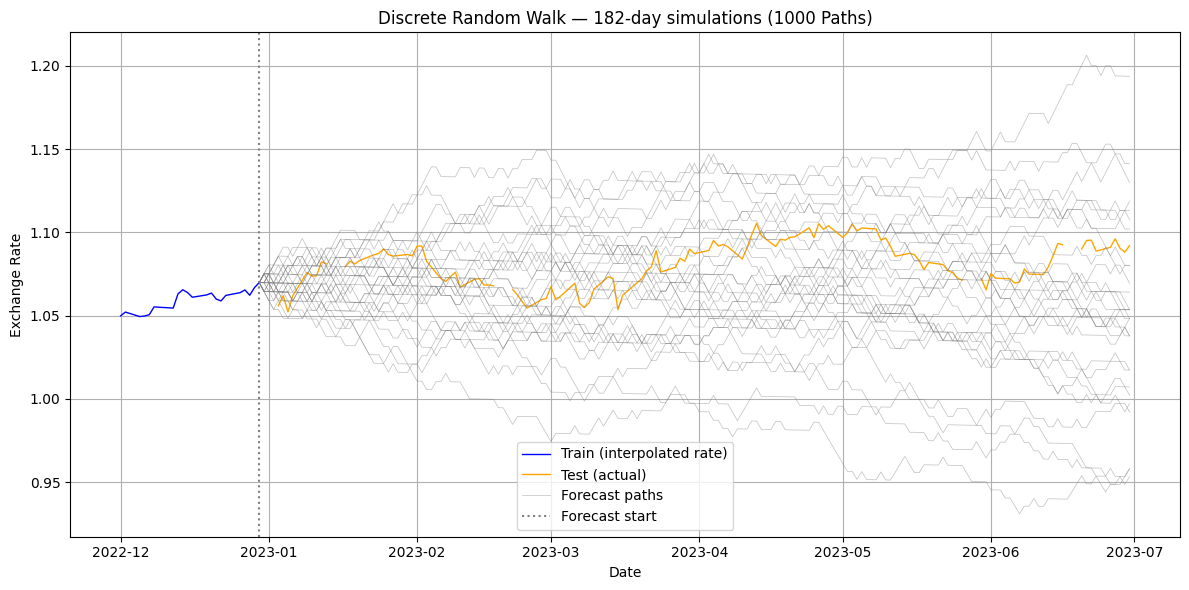

Expected RMSE (%): 3.80
Expected MAE (%): 3.24


In [100]:
# Discrete RW forecasting and evaluation
model_name="Discrete RandomWalk"
horizon="6M"
steps=182

# Simulate discrete random walks
walks = simulate_multiple_walks(
    p_dict=p_dict,
    horizon=steps,      
    n_paths=1000,
    seed=42
)

# Forecast from multiple walks
df_paths = forecast_from_multiple_walks(
    train_df=train_df_dexuseu, # historical data
    walks=walks,    # the simulated paths
    k=k,            # the same K value
    mu=estimated_mu # this must be your actual drift!
)

# Plot the paths against the historical data
plot_multiple_paths_vs_history(
    train_df=train_df_dexuseu,
    df_paths=df_paths,
    df_test=df_test,
    rate_col='rate',
    n_show=30
)

# Evaluation 
df_paths.index.name = 'path_number'
df_test = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)
df_paths.columns = pd.to_datetime(df_paths.columns)   # Convert column names to datetime

rmse_values, expected_rmse, mae_values, expected_mae = evaluate_rmse_mae_per_path(
    df_paths=df_paths,
    df_test=df_test,
    rate_col='rate'
)
print(f"Expected RMSE (%): {expected_rmse*100:.2f}")
print(f"Expected MAE (%): {expected_mae*100:.2f}")

# Prepare the summary metrics
summary = append_result(
    summary, 
    metrics = {
        "rmse(%)": float(expected_rmse*100),
        "mae(%)": float(expected_mae*100),
    },
    model_name=model_name, 
    horizon=horizon 
    )

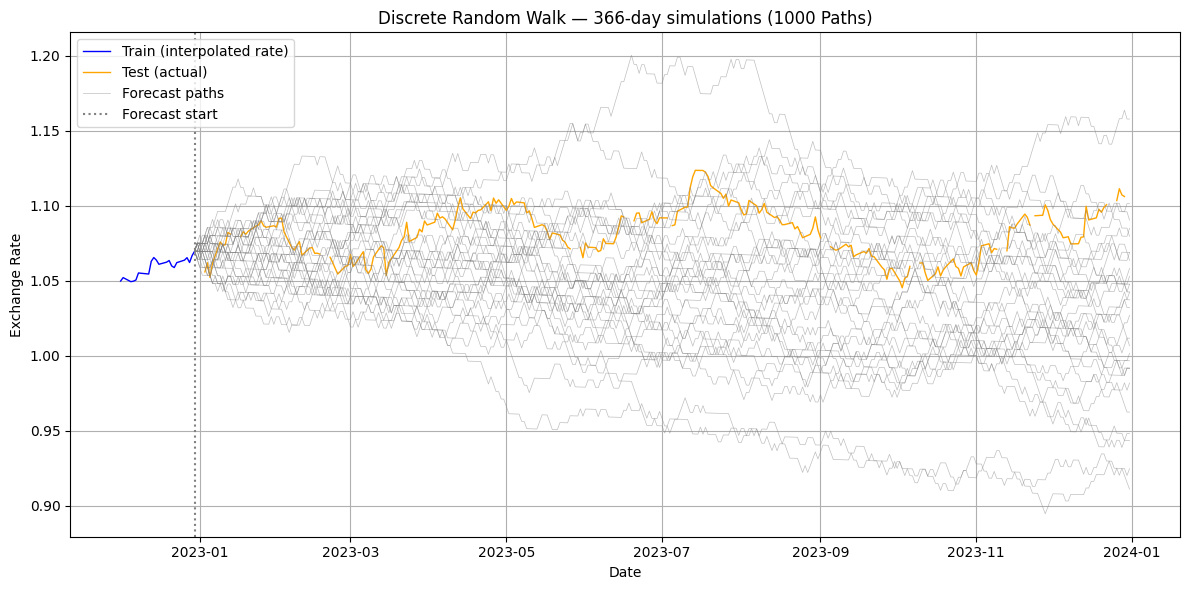

Expected RMSE (%): 5.28
Expected MAE (%): 4.51


In [101]:
# Discrete RW forecasting and evaluation
model_name="Discrete RandomWalk"
horizon="12M"
steps=366

# Simulate discrete random walks
walks = simulate_multiple_walks(
    p_dict=p_dict,
    horizon=steps,      
    n_paths=1000,
    seed=42
)

# Forecast from multiple walks
df_paths = forecast_from_multiple_walks(
    train_df=train_df_dexuseu, # historical data
    walks=walks,    # the simulated paths
    k=k,            # the same K value
    mu=estimated_mu # this must be your actual drift!
)

# Plot the paths against the historical data
plot_multiple_paths_vs_history(
    train_df=train_df_dexuseu,
    df_paths=df_paths,
    df_test=df_test,
    rate_col='rate',
    n_show=30
)

# Evaluation 
df_paths.index.name = 'path_number'
df_test = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)
df_paths.columns = pd.to_datetime(df_paths.columns)   # Convert column names to datetime

rmse_values, expected_rmse, mae_values, expected_mae = evaluate_rmse_mae_per_path(
    df_paths=df_paths,
    df_test=df_test,
    rate_col='rate'
)
print(f"Expected RMSE (%): {expected_rmse*100:.2f}")
print(f"Expected MAE (%): {expected_mae*100:.2f}")

# Prepare the summary metrics
summary = append_result(
    summary, 
    metrics = {
        "rmse(%)": float(expected_rmse*100),
        "mae(%)": float(expected_mae*100),
    },
    model_name=model_name, 
    horizon=horizon 
    )

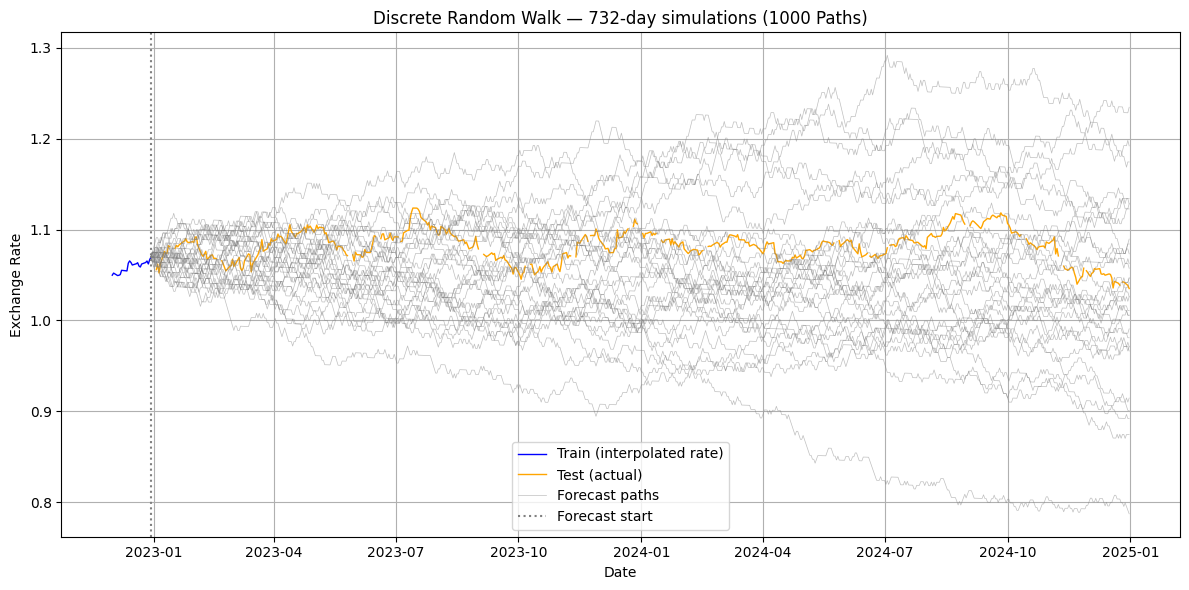

Expected RMSE (%): 7.04
Expected MAE (%): 6.03


In [102]:
# Discrete RW forecasting and evaluation
model_name="Discrete RandomWalk"
horizon="24M"
steps=366*2

# Simulate discrete random walks
walks = simulate_multiple_walks(
    p_dict=p_dict,
    horizon=steps,      
    n_paths=1000,
    seed=42
)

# Forecast from multiple walks
df_paths = forecast_from_multiple_walks(
    train_df=train_df_dexuseu, # historical data
    walks=walks,    # the simulated paths
    k=k,            # the same K value
    mu=estimated_mu # this must be your actual drift!
)

# Plot the paths against the historical data
plot_multiple_paths_vs_history(
    train_df=train_df_dexuseu,
    df_paths=df_paths,
    df_test=df_test,
    rate_col='rate',
    n_show=30
)

# Evaluation 
df_paths.index.name = 'path_number'
df_test = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)
df_paths.columns = pd.to_datetime(df_paths.columns)   # Convert column names to datetime

rmse_values, expected_rmse, mae_values, expected_mae = evaluate_rmse_mae_per_path(
    df_paths=df_paths,
    df_test=df_test,
    rate_col='rate'
)
print(f"Expected RMSE (%): {expected_rmse*100:.2f}")
print(f"Expected MAE (%): {expected_mae*100:.2f}")

# Prepare the summary metrics
summary = append_result(
    summary, 
    metrics = {
        "rmse(%)": float(expected_rmse*100),
        "mae(%)": float(expected_mae*100),
    },
    model_name=model_name, 
    horizon=horizon 
    )

In [103]:
summary

model horizon   rmse(%)    mae(%)
0  Discrete Random Walk      1M  1.953220  1.711284
1   Discrete RandomWalk      6M  3.797955  3.238881
2   Discrete RandomWalk     12M  5.282971  4.509970
3   Discrete RandomWalk     24M  7.042312  6.029502

### Continuos RW with drift

In [104]:
# model: X_t = X_{t-1} + mu + W_t
# W_t ~ N(0, sigma^2)
estimated_mu = -0.000057  #  df['log_rate'].diff().mean()

import numpy as np
import warnings
warnings.filterwarnings("ignore")

# --- 1) Estimate parameters from df['Wt'] ---
df= train_df.copy()
Wt_data = df['Wt'].dropna().values
sigma = Wt_data.std(ddof=0)  # standard deviation
sigma2 = sigma**2            # variance


#### Forecasting continuos RW with drift

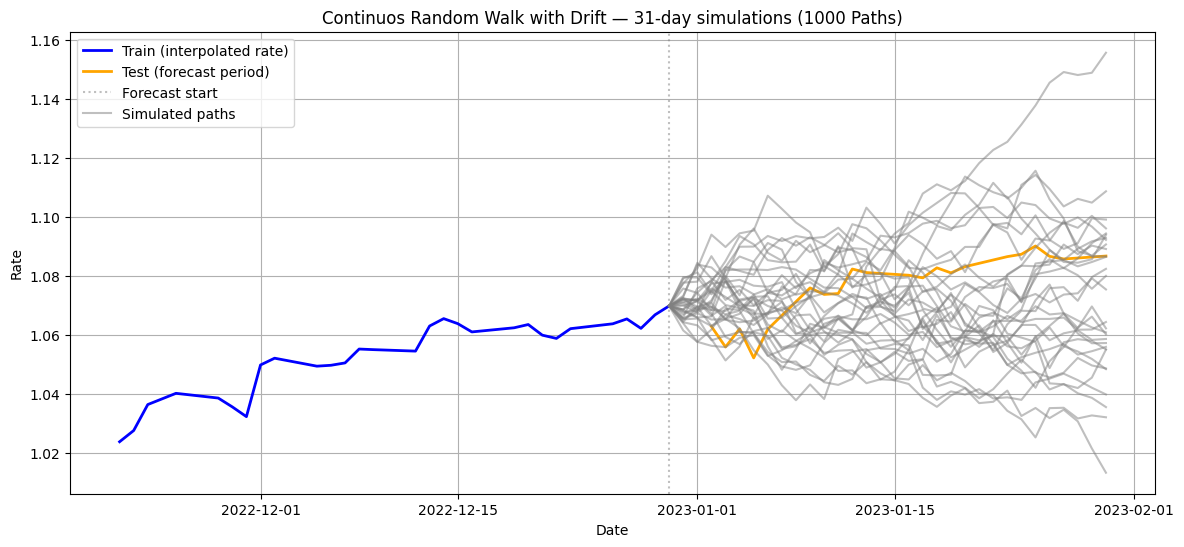

Evaluated dates: 19
Evaluated paths: 1000 of 1000
✅ Expected RMSE(%): 2.27
✅ Expected MAE(%): 1.98


In [105]:
# continuos RW with drift Forecasting and Evaluation 
model_name = 'Continuous RW with Drift'
horizon = '1M'
steps = 31

# Simulate paths with drift
all_paths = simulate_rw_with_drift_paths_and_plot(
    mu=estimated_mu,
    sigma=sigma,
    train_df=train_df,
    test_df=df_test,
    steps=steps,  
    n_sims=1000,
    n_show=30,
    rate_col='rate_interpolated',
    base_seed=42
)
# Evaluation 
df_test = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)
metrics_con_rw_drift = evaluate_simulations(all_paths, df_test)

# Prepare the summary metrics
summary = append_result(
    summary_df=summary,
    metrics={
        "rmse(%)": metrics_con_rw_drift['expected_rmse']*100,
        "mae(%)": metrics_con_rw_drift['expected_mae']*100,
    },
    model_name= model_name,
    horizon= horizon
)

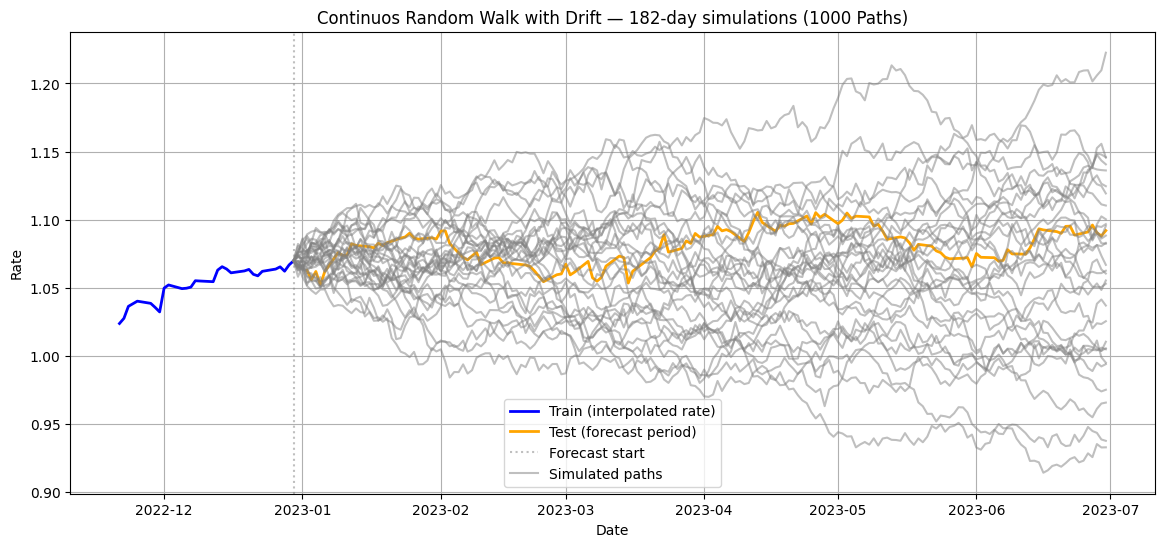

Evaluated dates: 125
Evaluated paths: 1000 of 1000
✅ Expected RMSE(%): 4.79
✅ Expected MAE(%): 4.09


In [106]:
# continuos RW with drift Forecasting and Evaluation 
model_name = 'Continuous RW with Drift'
horizon = '6M'
steps = 182

# Simulate paths with drift
all_paths = simulate_rw_with_drift_paths_and_plot(
    mu=estimated_mu,
    sigma=sigma,
    train_df=train_df,
    test_df=df_test,
    steps=steps,  
    n_sims=1000,
    n_show=30,
    rate_col='rate_interpolated',
    base_seed=42
)
# Evaluation 
df_test = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)
metrics_con_rw_drift = evaluate_simulations(all_paths, df_test)

# Prepare the summary metrics
summary = append_result(
    summary_df=summary,
    metrics={
        "rmse(%)": metrics_con_rw_drift['expected_rmse']*100,
        "mae(%)": metrics_con_rw_drift['expected_mae']*100,
    },
    model_name= model_name,
    horizon= horizon
)

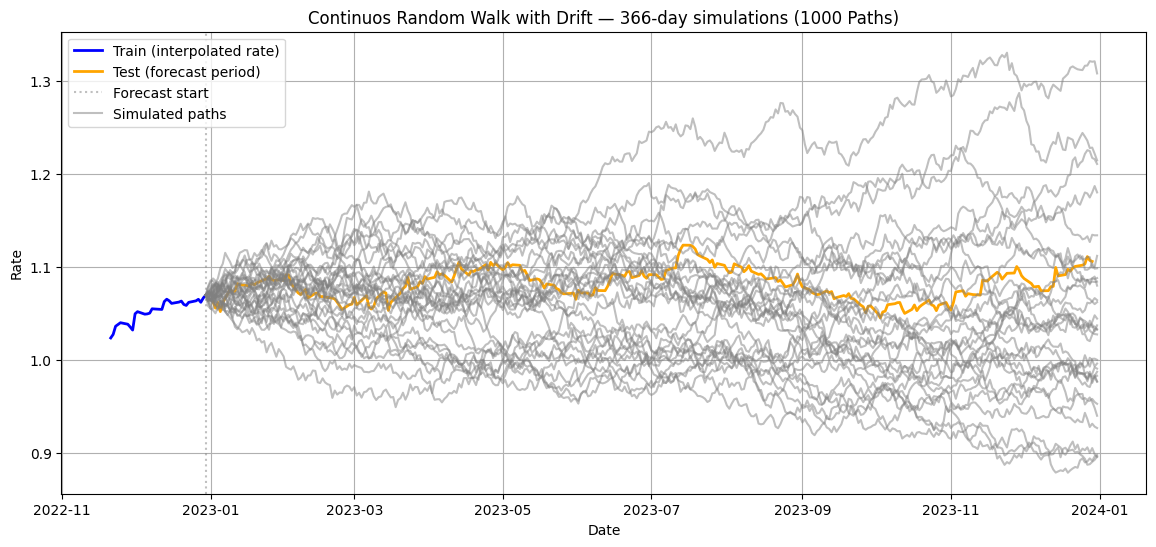

Evaluated dates: 249
Evaluated paths: 1000 of 1000
✅ Expected RMSE(%): 6.68
✅ Expected MAE(%): 5.69


In [107]:
# continuos RW with drift Forecasting and Evaluation 
model_name = 'Continuous RW with Drift'
horizon = '12M'
steps = 366

# Simulate paths with drift
all_paths = simulate_rw_with_drift_paths_and_plot(
    mu=estimated_mu,
    sigma=sigma,
    train_df=train_df,
    test_df=df_test,
    steps=steps,  
    n_sims=1000,
    n_show=30,
    rate_col='rate_interpolated',
    base_seed=42
)
# Evaluation 
df_test = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)
metrics_con_rw_drift = evaluate_simulations(all_paths, df_test)

# Prepare the summary metrics
summary = append_result(
    summary_df=summary,
    metrics={
        "rmse(%)": metrics_con_rw_drift['expected_rmse']*100,
        "mae(%)": metrics_con_rw_drift['expected_mae']*100,
    },
    model_name= model_name,
    horizon= horizon
)

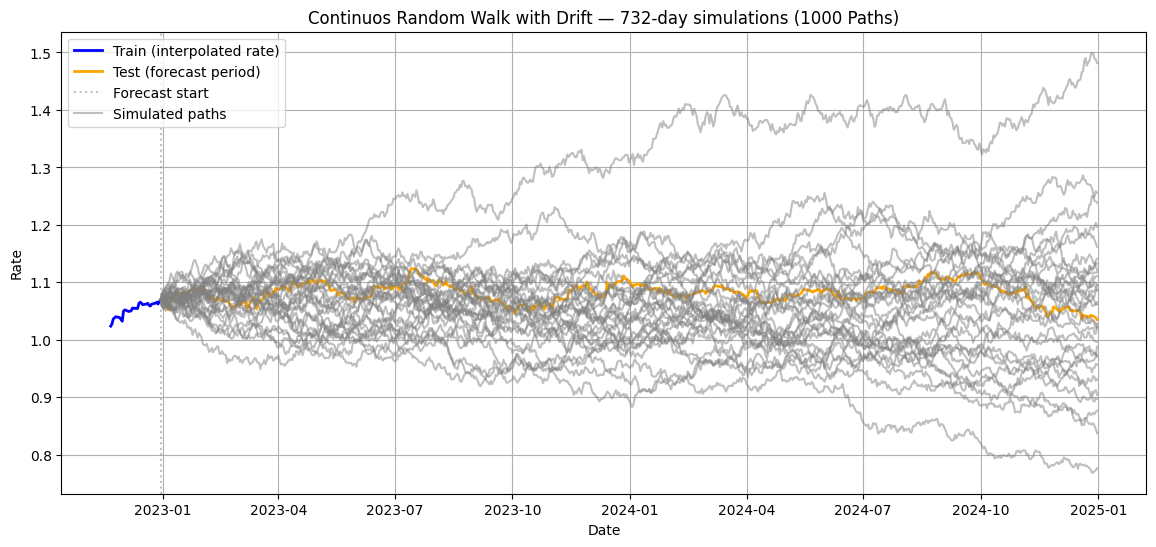

Evaluated dates: 500
Evaluated paths: 1000 of 1000
✅ Expected RMSE(%): 9.30
✅ Expected MAE(%): 7.94


In [108]:
# continuos RW with drift Forecasting and Evaluation 
model_name = 'Continuous RW with Drift'
horizon = '24M'
steps = 366*2

# Simulate paths with drift
all_paths = simulate_rw_with_drift_paths_and_plot(
    mu=estimated_mu,
    sigma=sigma,
    train_df=train_df,
    test_df=df_test,
    steps=steps,  
    n_sims=1000,
    n_show=30,
    rate_col='rate_interpolated',
    base_seed=42
)
# Evaluation 
df_test = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)
metrics_con_rw_drift = evaluate_simulations(all_paths, df_test)

# Prepare the summary metrics
summary = append_result(
    summary_df=summary,
    metrics={
        "rmse(%)": metrics_con_rw_drift['expected_rmse']*100,
        "mae(%)": metrics_con_rw_drift['expected_mae']*100,
    },
    model_name= model_name,
    horizon= horizon
)

### Continuos RW without Drift

In [109]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")



# generic model: X_t' = 
#           phi_1 * X_{t-1}' - phi_2 * X_{t-2}' - ... - phi_p * X_{t-p}' 
#           + mu 
#           + e_t + theta_1 * e_{t-1} + theta_2 * e_{t-2} + ... + theta_q * e_{t-q}

# model ARIMA(0,1,0) without intercept: 
#       X_t' = e_t
#       X_t' = X_t - X_{t-1} = e_t
# 

In [110]:
# train_df is already loaded with index as date
series = train_df['log_rate'] # X_t = log(rate_t)

# Using auto arima to selct p and q
import pmdarima as pm

auto_model = pm.auto_arima(train_df['log_rate'],
                           start_p=0, max_p=0,
                           start_q=0, max_q=0,
                           d=1, seasonal=False, trace=True,
                           error_action='ignore', suppress_warnings=True,
                           with_intercept=True)

print(auto_model.summary())

# Get the selected (p,d,q) and whether an intercept was used
order = auto_model.order                       # e.g., (1, 1, 0)
trend = 'c' if auto_model.with_intercept else 'n'  # 'c' => includes drift (intercept)
print(f'Selected ARIMA order: {order}, Trend: {trend}')

# Refit on your training log series with statsmodels
sm_model = ARIMA(train_df['log_rate'], order=order, trend=trend)
res = sm_model.fit()
print(f'Arima Params: {res.params.to_dict()}')

# Load test data
test_df = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16227.269, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16229.038, Time=0.37 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.174 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2085
Model:               SARIMAX(0, 1, 0)   Log Likelihood                8115.519
Date:                Mon, 18 Aug 2025   AIC                         -16229.038
Time:                        00:19:49   BIC                         -16223.396
Sample:                    01-05-2015   HQIC                        -16226.971
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

In [111]:
# model ARIMA(0,1,0) without intercept: 
#       X_t' = e_t
#       X_t' = X_t - X_{t-1} = e_t
#       e_t ~ N(0, sigma^2) ~ N(0, 2.426e-05)

#### Forecasting continuos RW without drift

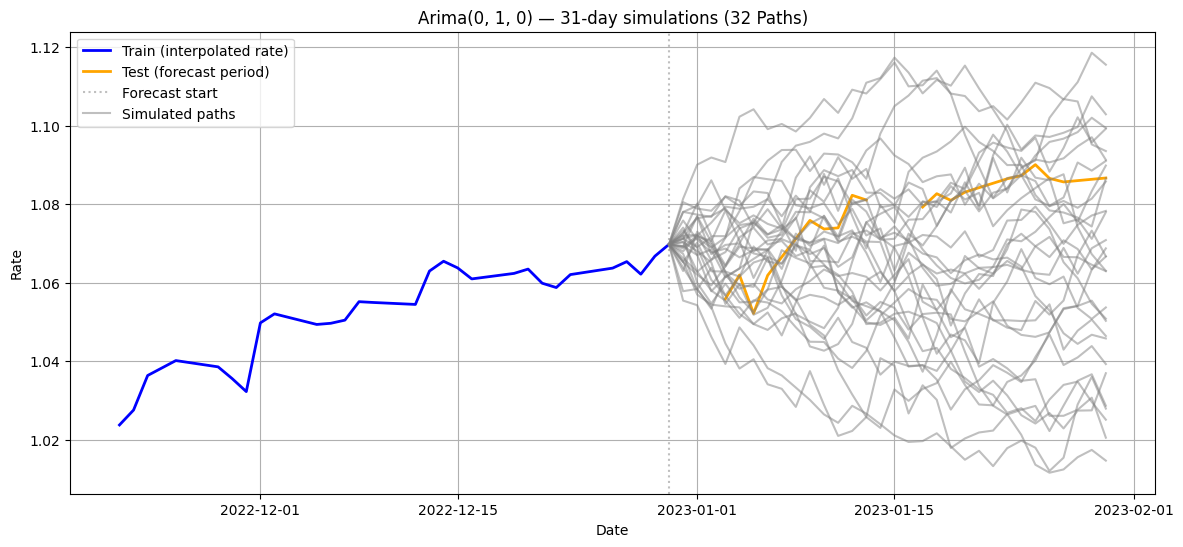

Evaluated dates: 19
Evaluated paths: 1000 of 1000
✅ Expected RMSE(%): 2.26
✅ Expected MAE(%): 1.98


In [112]:
# ARIMA Forecasting and Evaluation 
model_name = 'Continuous RW'
horizon = '1M'
steps = 31

# 1) Simulate paths and plot
all_paths = simulate_paths_and_plot(res, train_df, 
                                    test_df, steps=steps, 
                                    n_sims=1000,
                                    n_show=30, 
                                    rate_col='rate_interpolated',
                                    base_seed=42
                                    )
# 2) Evaluate simulations
metrics_arima = evaluate_simulations(all_paths, test_df, rate_col='rate')

# 3) Prepare the summary metrics
summary = append_result(
    summary_df=summary,
    metrics={
        "rmse(%)": metrics_arima['expected_rmse']*100,
        "mae(%)": metrics_arima['expected_mae']*100,
    },
    model_name= model_name,
    horizon= horizon
)

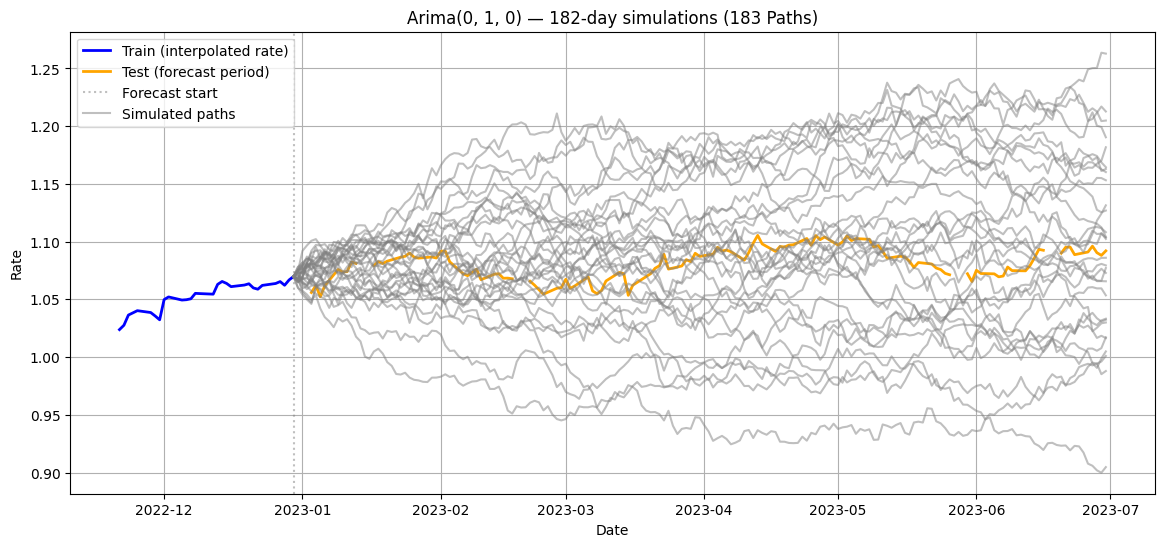

Evaluated dates: 125
Evaluated paths: 1000 of 1000
✅ Expected RMSE(%): 4.86
✅ Expected MAE(%): 4.18


In [113]:
# ARIMA Forecasting and Evaluation 
model_name = 'Continuous RW'
horizon = '6M'
steps = 182

# 1) Simulate paths and plot
all_paths = simulate_paths_and_plot(res, train_df, 
                                    test_df, steps=steps, 
                                    n_sims=1000,
                                    n_show=30, 
                                    rate_col='rate_interpolated',
                                    base_seed=42
                                    )
# 2) Evaluate simulations
metrics_arima = evaluate_simulations(all_paths, test_df, rate_col='rate')

# 3) Prepare the summary metrics
summary = append_result(
    summary_df=summary,
    metrics={
        "rmse(%)": metrics_arima['expected_rmse']*100,
        "mae(%)": metrics_arima['expected_mae']*100,
    },
    model_name= model_name,
    horizon= horizon
)

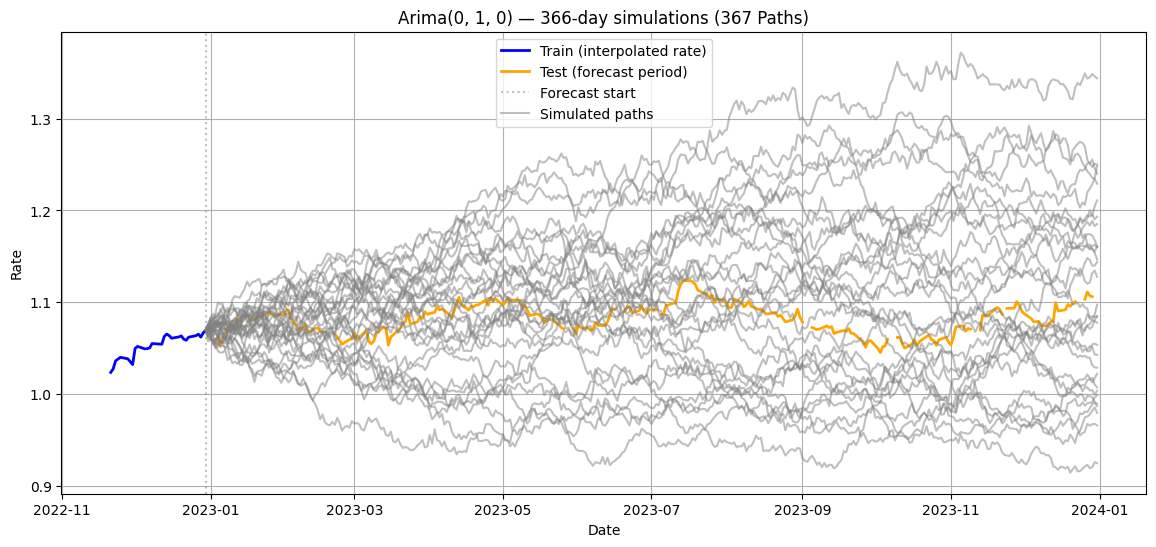

Evaluated dates: 249
Evaluated paths: 1000 of 1000
✅ Expected RMSE(%): 6.69
✅ Expected MAE(%): 5.72


In [114]:
# ARIMA Forecasting and Evaluation 
model_name = 'Continuous RW'
horizon = '12M'
steps = 366

# 1) Simulate paths and plot
all_paths = simulate_paths_and_plot(res, train_df, 
                                    test_df, steps=steps, 
                                    n_sims=1000,
                                    n_show=30, 
                                    rate_col='rate_interpolated',
                                    base_seed=42
                                    )
# 2) Evaluate simulations
metrics_arima = evaluate_simulations(all_paths, test_df, rate_col='rate')

# 3) Prepare the summary metrics
summary = append_result(
    summary_df=summary,
    metrics={
        "rmse(%)": metrics_arima['expected_rmse']*100,
        "mae(%)": metrics_arima['expected_mae']*100,
    },
    model_name= model_name,
    horizon= horizon
)

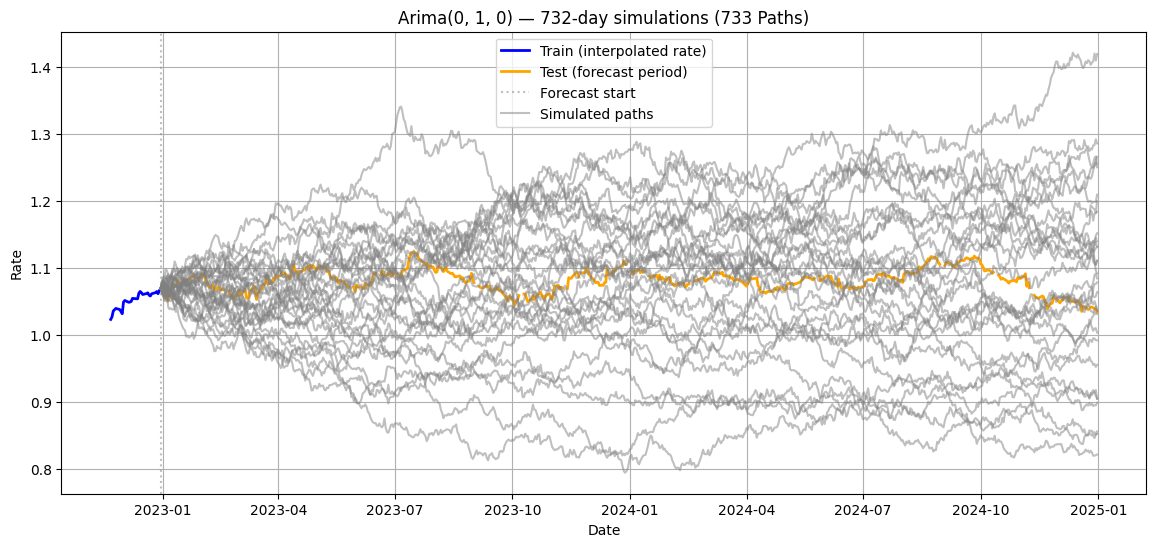

Evaluated dates: 500
Evaluated paths: 1000 of 1000
✅ Expected RMSE(%): 9.41
✅ Expected MAE(%): 8.02


In [115]:
# ARIMA Forecasting and Evaluation 
model_name = 'Continuous RW'
horizon = '24M'
steps = 366*2

# 1) Simulate paths and plot
all_paths = simulate_paths_and_plot(res, train_df, 
                                    test_df, steps=steps, 
                                    n_sims=1000,
                                    n_show=30, 
                                    rate_col='rate_interpolated',
                                    base_seed=42
                                    )
# 2) Evaluate simulations
metrics_arima = evaluate_simulations(all_paths, test_df, rate_col='rate')

# 3) Prepare the summary metrics
summary = append_result(
    summary_df=summary,
    metrics={
        "rmse(%)": metrics_arima['expected_rmse']*100,
        "mae(%)": metrics_arima['expected_mae']*100,
    },
    model_name= model_name,
    horizon= horizon
)

In [116]:
summary

model horizon   rmse(%)    mae(%)
0       Discrete Random Walk      1M  1.953220  1.711284
1        Discrete RandomWalk      6M  3.797955  3.238881
2        Discrete RandomWalk     12M  5.282971  4.509970
3        Discrete RandomWalk     24M  7.042312  6.029502
4   Continuous RW with Drift      1M  2.267181  1.977396
5   Continuous RW with Drift      6M  4.788845  4.085394
6   Continuous RW with Drift     12M  6.675744  5.690613
7   Continuous RW with Drift     24M  9.302447  7.942937
8              Continuous RW      1M  2.260765  1.979055
9              Continuous RW      6M  4.858307  4.180052
10             Continuous RW     12M  6.687689  5.717904
11             Continuous RW     24M  9.405833  8.017717

### ARIMA(1,1,0) 

In [117]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# train_df is already loaded with index as date
series = train_df['log_rate'] # X_t = log(rate_t)

# model: X_t' = 
#           phi_1 * X_{t-1}' - phi_2 * X_{t-2}' - ... - phi_p * X_{t-p}' 
#           + mu 
#           + e_t + theta_1 * e_{t-1} + theta_2 * e_{t-2} + ... + theta_q * e_{t-q}




In [118]:
# DETERMINE d (differencing order) using ADF and KPSS tests
# from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

# Direct ADF test  Augmented Dickey-Fuller already done in preprocessing
adf_res = adfuller(train_df['log_rate'])
print("ADF p-value:", adf_res[1])

ADF p-value: 0.12271024894831561


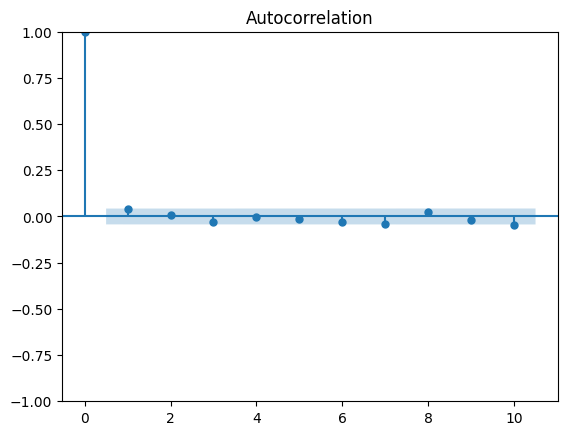

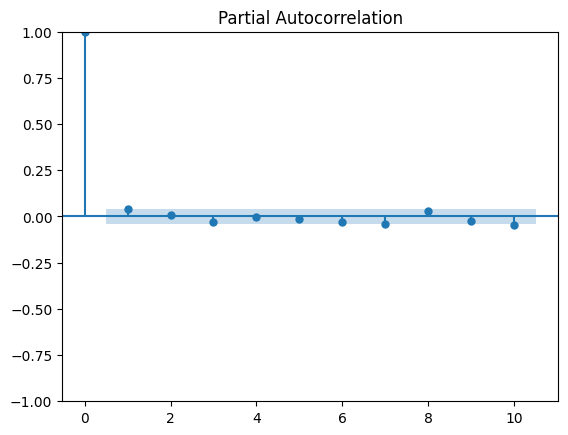

In [119]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# diff_series = train_df['log_rate'].diff().dropna()
diff_series = train_df['Wt'].dropna()

# selct q: with ACF autocorrelation function
plot_acf(diff_series, lags=10)
plt.show()

# for select p with PACF partial autocorrelation function
plot_pacf(diff_series, lags=10)
plt.show()

In [120]:
# Using auto arima to selct p and q
import pmdarima as pm

auto_model = pm.auto_arima(train_df['log_rate'],
                           start_p=0, max_p=5,
                           start_q=0, max_q=5,
                           d=1, seasonal=False, trace=True,
                           error_action='ignore', suppress_warnings=True,
                           with_intercept=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16227.269, Time=0.62 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16229.198, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16229.144, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16229.038, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-16227.233, Time=0.45 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16227.212, Time=0.62 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16221.266, Time=0.85 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-16230.987, Time=0.30 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-16229.026, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-16229.003, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-16230.934, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-16227.024, Time=0.66 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 6.266 seconds
                               SARIMAX Results                  

In [121]:
# model ARIMA(1,1,0) without intercept: 
#       X_t' = 
#           phi_1 * X_{t-1}' 
#           + e_t
#
#  X_t' = 0.0435 * X_{t-1}' + N(0, sigma2 = 2.422e-05)
#  
#  X_t' = X_t - X_{t-1}

In [122]:
# 1) Get the selected (p,d,q) and whether an intercept was used
order = auto_model.order                       # e.g., (1, 1, 0)
trend = 'c' if auto_model.with_intercept else 'n'  # 'c' => includes drift (intercept)

# 2) Refit on your training log series with statsmodels
sm_model = ARIMA(train_df['log_rate'], order=order, trend=trend)
res = sm_model.fit()

In [123]:
# Load test data
test_df = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)

#### Forecasting ARIMA

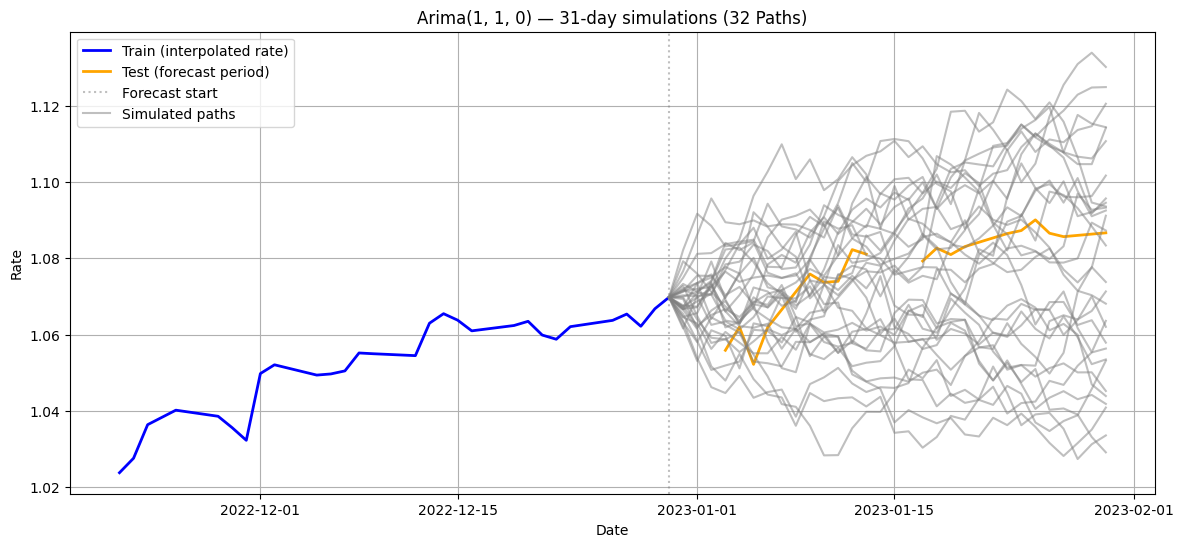

Evaluated dates: 19
Evaluated paths: 1000 of 1000
✅ Expected RMSE(%): 2.29
✅ Expected MAE(%): 2.01


In [124]:
# ARIMA Forecasting and Evaluation
model_name = 'Arima(1,1,0)'
horizon = '1M'
steps = 31

# 1) Simulate paths and plot
all_paths = simulate_paths_and_plot(res, train_df, 
                                    test_df, steps=steps, 
                                    n_sims=1000,
                                    n_show=30, 
                                    rate_col='rate_interpolated',
                                    base_seed=42
                                    )
# 2) Evaluate simulations
metrics_arima = evaluate_simulations(all_paths, test_df, rate_col='rate')

# 3) Prepare the summary metrics
summary = append_result(
    summary_df=summary,
    metrics={
        "rmse(%)": metrics_arima['expected_rmse']*100,
        "mae(%)": metrics_arima['expected_mae']*100,
    },
    model_name= model_name,
    horizon= horizon
)

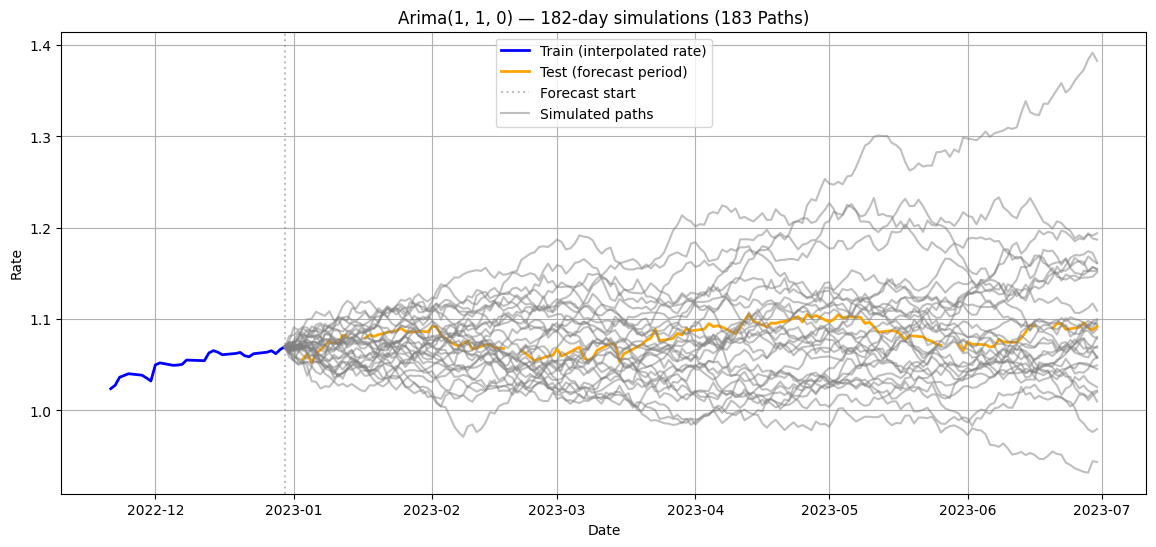

Evaluated dates: 125
Evaluated paths: 1000 of 1000
✅ Expected RMSE(%): 5.03
✅ Expected MAE(%): 4.31


In [125]:
# ARIMA Forecasting and Evaluation
model_name = 'Arima(1,1,0)'
horizon = '6M'
steps = 182

# 1) Simulate paths and plot
all_paths = simulate_paths_and_plot(res, train_df, 
                                    test_df, steps=steps, 
                                    n_sims=1000,
                                    n_show=30, 
                                    rate_col='rate_interpolated',
                                    base_seed=42
                                    )
# 2) Evaluate simulations
metrics_arima = evaluate_simulations(all_paths, test_df, rate_col='rate')

# 3) Prepare the summary metrics
summary = append_result(
    summary_df=summary,
    metrics={
        "rmse(%)": metrics_arima['expected_rmse']*100,
        "mae(%)": metrics_arima['expected_mae']*100,
    },
    model_name= model_name,
    horizon= horizon
)

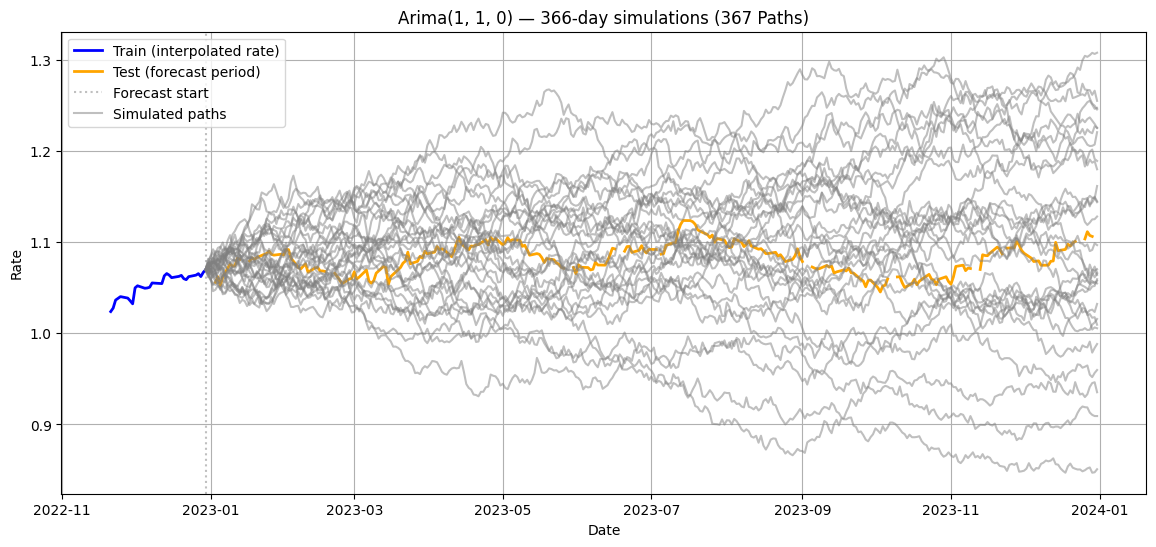

Evaluated dates: 249
Evaluated paths: 1000 of 1000
✅ Expected RMSE(%): 7.04
✅ Expected MAE(%): 5.98


In [126]:
# ARIMA Forecasting and Evaluation
model_name = 'Arima(1,1,0)'
horizon = '12M'
steps = 366

# 1) Simulate paths and plot
all_paths = simulate_paths_and_plot(res, train_df, 
                                    test_df, steps=steps, 
                                    n_sims=1000,
                                    n_show=30, 
                                    rate_col='rate_interpolated',
                                    base_seed=42
                                    )
# 2) Evaluate simulations
metrics_arima = evaluate_simulations(all_paths, test_df, rate_col='rate')

# 3) Prepare the summary metrics
summary = append_result(
    summary_df=summary,
    metrics={
        "rmse(%)": metrics_arima['expected_rmse']*100,
        "mae(%)": metrics_arima['expected_mae']*100,
    },
    model_name= model_name,
    horizon= horizon
)

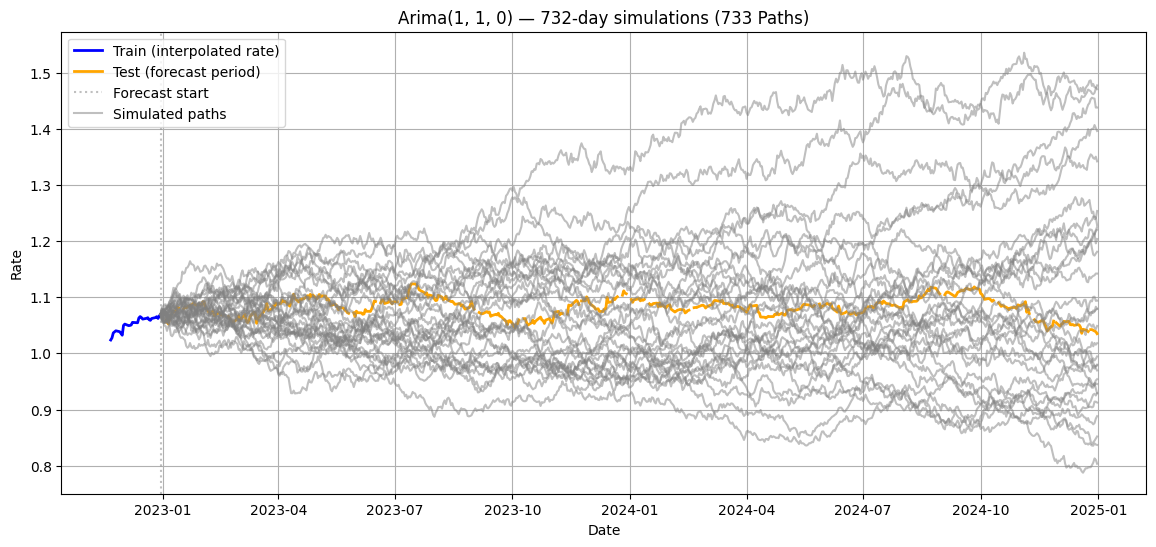

Evaluated dates: 500
Evaluated paths: 1000 of 1000
✅ Expected RMSE(%): 9.74
✅ Expected MAE(%): 8.32


In [127]:
# ARIMA Forecasting and Evaluation
model_name = 'Arima(1,1,0)'
horizon = '24M'
steps = 366*2

# 1) Simulate paths and plot
all_paths = simulate_paths_and_plot(res, train_df, 
                                    test_df, steps=steps, 
                                    n_sims=1000,
                                    n_show=30, 
                                    rate_col='rate_interpolated',
                                    base_seed=42
                                    )
# 2) Evaluate simulations
metrics_arima = evaluate_simulations(all_paths, test_df, rate_col='rate')

# 3) Prepare the summary metrics
summary = append_result(
    summary_df=summary,
    metrics={
        "rmse(%)": metrics_arima['expected_rmse']*100,
        "mae(%)": metrics_arima['expected_mae']*100,
    },
    model_name= model_name,
    horizon= horizon
)

In [128]:
summary

model horizon   rmse(%)    mae(%)
0       Discrete Random Walk      1M  1.953220  1.711284
1        Discrete RandomWalk      6M  3.797955  3.238881
2        Discrete RandomWalk     12M  5.282971  4.509970
3        Discrete RandomWalk     24M  7.042312  6.029502
4   Continuous RW with Drift      1M  2.267181  1.977396
5   Continuous RW with Drift      6M  4.788845  4.085394
6   Continuous RW with Drift     12M  6.675744  5.690613
7   Continuous RW with Drift     24M  9.302447  7.942937
8              Continuous RW      1M  2.260765  1.979055
9              Continuous RW      6M  4.858307  4.180052
10             Continuous RW     12M  6.687689  5.717904
11             Continuous RW     24M  9.405833  8.017717
12              Arima(1,1,0)      1M  2.294910  2.006361
13              Arima(1,1,0)      6M  5.032590  4.314017
14              Arima(1,1,0)     12M  7.040806  5.975056
15              Arima(1,1,0)     24M  9.740149  8.322084

In [129]:
# lower than RW, ARIMA is better than RW for 1 month, 6 , 12, 24 month ahead forecasts

### Structural Model + AR(1)

In [130]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# ------------------------
# 1) Load data
# ------------------------
train_df = pd.read_csv('../2. preprocesing/train_df_dexuseu.csv', parse_dates=True, index_col=0).sort_index()
test_df  = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv',  parse_dates=True, index_col='date').sort_index()

m1_eu  = pd.read_csv('../2. preprocesing/M1_EU_daily.csv',                 parse_dates=True, index_col=0).sort_index()
m1_us  = pd.read_csv('../2. preprocesing/M1_USA_daily.csv',                parse_dates=True, index_col=0).sort_index()
r3m_eu = pd.read_csv('../2. preprocesing/interest_rate_3m_EU_daily.csv',   parse_dates=True, index_col=0).sort_index()
r3m_us = pd.read_csv('../2. preprocesing/interest_rate_3m_USA_daily.csv',  parse_dates=True, index_col=0).sort_index()
ip_eu  = pd.read_csv('../2. preprocesing/INDPRO_EU_daily.csv',             parse_dates=True, index_col=0).sort_index()
ip_us  = pd.read_csv('../2. preprocesing/INDPRO_USA_daily.csv',            parse_dates=True, index_col=0).sort_index()

# Ensure expected column names (robust to unknown original headers)
def set_single_col(df, name):
    if df.shape[1] != 1:
        raise ValueError(f"Expected 1 column in {name}, got {df.shape[1]}")
    df.columns = [name]
    return df

m1_eu  = set_single_col(m1_eu,  'M1_EU')
m1_us  = set_single_col(m1_us,  'M1_US')
r3m_eu = set_single_col(r3m_eu, 'R3M_EU')
r3m_us = set_single_col(r3m_us, 'R3M_US')
ip_eu  = set_single_col(ip_eu,  'IP_EU')
ip_us  = set_single_col(ip_us,  'IP_US')

# ------------------------
# 2) Build a base daily index (train + test + fundamentals)
#    Use the union so we never drop test dates again.
# ------------------------
base_index = train_df.index.union(test_df.index)\
    .union(m1_eu.index).union(m1_us.index)\
    .union(r3m_eu.index).union(r3m_us.index)\
    .union(ip_eu.index).union(ip_us.index)

# enforce daily regularity if you prefer a contiguous D-frequency grid
base_index = pd.date_range(base_index.min(), base_index.max(), freq='D')

# ------------------------
# 3) Reindex and merge (left joins on the base index)
#    Forward-fill only fundamentals; do NOT fabricate FX values.
# ------------------------
fx_cols = ['rate', 'rate_interpolated', 'log_rate']
fx = train_df.reindex(base_index)[fx_cols]  # keep train values; outside train these are NaN

# fundamentals: forward-fill to daily (they are daily already, but to align holidays/missing days)
funds = (
    m1_us.reindex(base_index).ffill()
    .join(m1_eu.reindex(base_index).ffill())
    .join(r3m_us.reindex(base_index).ffill())
    .join(r3m_eu.reindex(base_index).ffill())
    .join(ip_us.reindex(base_index).ffill())
    .join(ip_eu.reindex(base_index).ffill())
)

df_all = fx.join(funds, how='left')

# ------------------------
# 4) Construct structural features
# ------------------------
# Guard against non-positive values in logs
for col in ['M1_US','M1_EU','IP_US','IP_EU']:
    if (df_all[col] <= 0).any():
        raise ValueError(f"{col} has non-positive values; cannot take log.")

df_all['m_diff'] = np.log(df_all['M1_US']) - np.log(df_all['M1_EU'])
df_all['y_diff'] = np.log(df_all['IP_US'])  - np.log(df_all['IP_EU'])
df_all['r_diff'] = df_all['R3M_US'] - df_all['R3M_EU']

feature_cols = ['m_diff','y_diff','r_diff']
y_col = 'log_rate'
rate_col = 'rate_interpolated'  # use your interpolated daily rate for sim/eval


df_all

rate  rate_interpolated  log_rate         M1_US         M1_EU  \
2015-01-01     NaN                NaN       NaN   2941.100000  5.969987e+06   
2015-01-02     NaN                NaN       NaN   2942.341935  5.972024e+06   
2015-01-03     NaN                NaN       NaN   2943.583871  5.974062e+06   
2015-01-04     NaN                NaN       NaN   2944.825806  5.976099e+06   
2015-01-05  1.1918             1.1918  0.175465   2946.067742  5.978137e+06   
...            ...                ...       ...           ...           ...   
2024-12-27     NaN                NaN       NaN  18511.800000  1.065264e+07   
2024-12-28     NaN                NaN       NaN  18511.800000  1.065482e+07   
2024-12-29     NaN                NaN       NaN  18511.800000  1.065701e+07   
2024-12-30     NaN                NaN       NaN  18511.800000  1.065919e+07   
2024-12-31     NaN                NaN       NaN  18511.800000  1.066137e+07   

            R3M_US    R3M_EU       IP_US       IP_EU    m_diff    y_diff  \
2015-01-01    0.03  0.062667  102.346000   99.691692 -7.615716  0.026277   
2015-01-02    0.03  0.062667  102.332045   99.691692 -7.615635  0.026141   
2015-01-03    0.03  0.062667  102.318090   99.691692 -7.615554  0.026004   
2015-01-04    0.03  0.062667  102.304135   99.691692 -7.615474  0.025868   
2015-01-05    0.03  0.062667  102.290181   99.691692 -7.615393  0.025731   
...            ...       ...         ...         ...       ...       ...   
2024-12-27    4.27  2.816091  102.583500  108.090992 -6.355155 -0.052296   
2024-12-28    4.27  2.816091  102.583500  108.090992 -6.355360 -0.052296   
2024-12-29    4.27  2.816091  102.583500  108.090992 -6.355564 -0.052296   
2024-12-30    4.27  2.816091  102.583500  108.090992 -6.355769 -0.052296   
2024-12-31    4.27  2.816091  102.583500  108.090992 -6.355974 -0.052296   

              r_diff  
2015-01-01 -0.032667  
2015-01-02 -0.032667  
2015-01-03 -0.032667  
2015-01-04 -0.032667  
2015-01-05 -0.032667  
...              ...  
2024-12-27  1.453909  
2024-12-28  1.453909  
2024-12-29  1.453909  
2024-12-30  1.453909  
2024-12-31  1.453909  

[3653 rows x 12 columns]

#### Dornbusch-Frankel model

In [131]:
# Structural model (OLS) 
# log_rate = β0 + β1 * m_diff + β2 * y_diff + β3 * r_diff + u

# AR(1) for u
# u_t =ρ u_t−1 + ε_t, ε_t ~ N(0, σ²)

# ------------------------
# 5) Fit OLS ONLY on the train window
# ------------------------
last_train_date = train_df.index.max()
train_mask = (df_all.index <= last_train_date)

df_train = df_all.loc[train_mask, [y_col, *feature_cols]].dropna()
if df_train.empty:
    raise ValueError("No rows to fit after dropna(). Check column names and merges.")

X = sm.add_constant(df_train[feature_cols])
y = df_train[y_col]
model = sm.OLS(y, X).fit()
print(model.summary())

# Residuals aligned to df_all index (NaN outside train)
residuals = pd.Series(np.nan, index=df_all.index, name='resid')
residuals.loc[df_train.index] = model.resid



                            OLS Regression Results                            
Dep. Variable:               log_rate   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     34.39
Date:                Mon, 18 Aug 2025   Prob (F-statistic):           1.08e-21
Time:                        00:31:20   Log-Likelihood:                 3414.9
No. Observations:                2085   AIC:                            -6822.
Df Residuals:                    2081   BIC:                            -6799.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0880      0.012      7.180      0.0

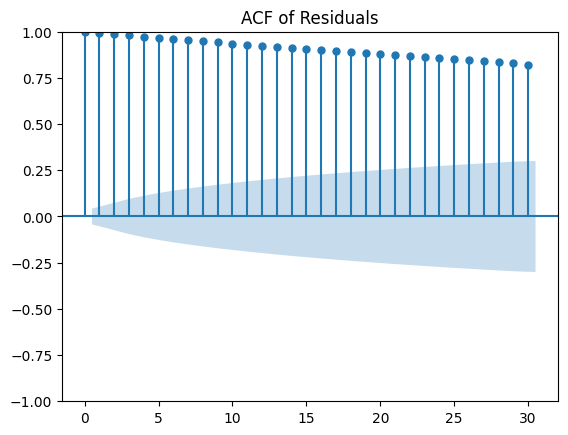

Text(0.5, 1.0, 'PACF of Residuals')

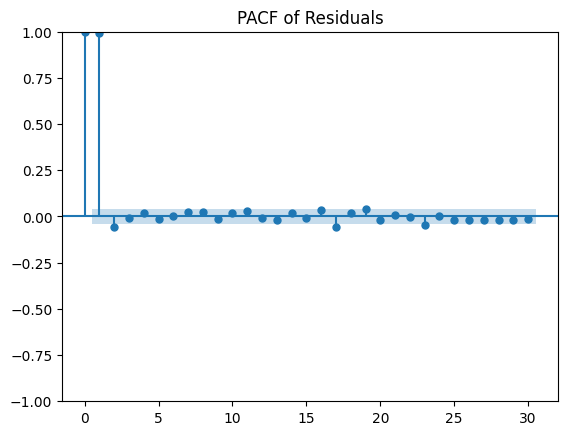

In [132]:
# test the acf and pacf of residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(residuals.dropna(), lags=30)
plt.title('ACF of Residuals')           
plt.show()
plot_pacf(residuals.dropna(), lags=30)
plt.title('PACF of Residuals')
# ------------------------

In [133]:
from statsmodels.tsa.ar_model import AutoReg

# Drop NaN values from residuals before fitting AR(1)
residuals_clean = residuals.dropna()

# Fit AR(1) on clean residuals
ar_model = AutoReg(residuals_clean, lags=1).fit()
phi = ar_model.params[1]  # AR(1) coefficient
sigma = np.std(ar_model.resid)  # std of innovation

print(f"Estimated phi (AR1): {phi:.4f}, sigma: {sigma:.4f}")


Estimated phi (AR1): 0.9943, sigma: 0.0049


#### Forecasting structural model + AR(1)

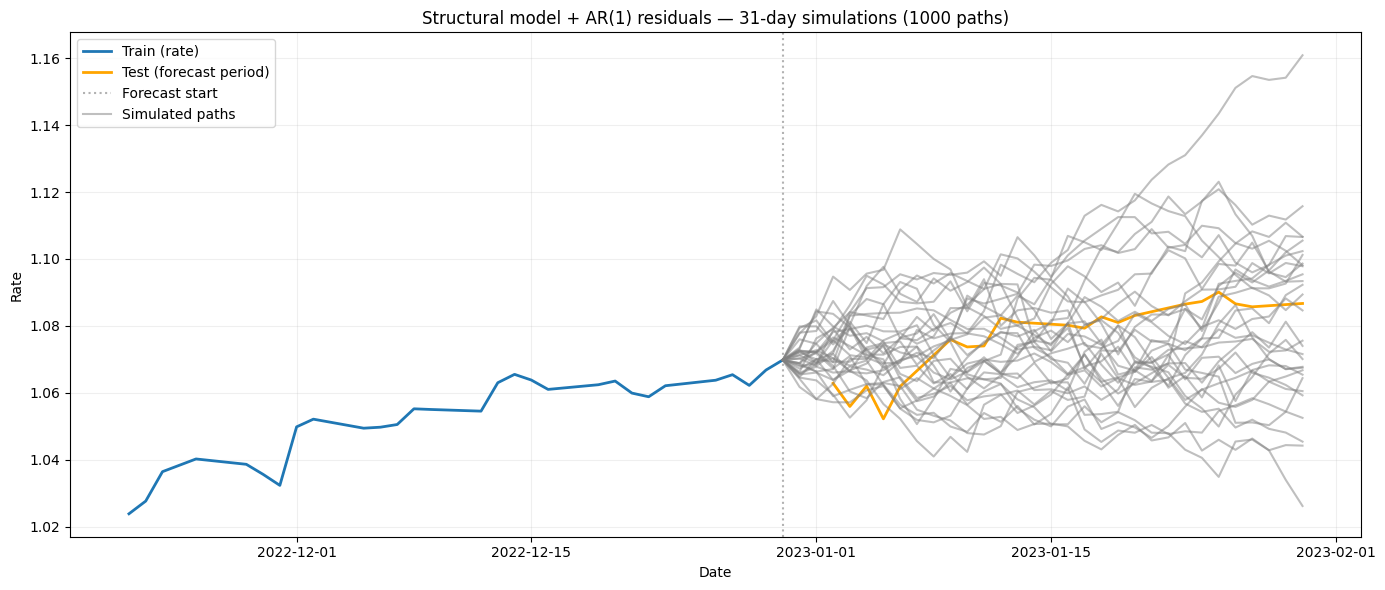

AR(1) params: {'phi': 0.9943272135908586, 'sigma': 0.004943102907961243}
Evaluated dates: 19
Evaluated paths: 1000 of 1000
✅ Expected RMSE (mean over paths): 0.020129
✅ Expected MAE  (mean over paths): 0.017556


In [134]:
# ------------------------
# 6) Prepare exog_future from REAL fundamentals (test window)
# ------------------------
model_name="StructuralModel+AR(1)"
horizon="1M"
steps = 31       

n_sims = 1000          # number of simulation paths
start_fc = last_train_date + pd.Timedelta(days=1)
end_fc   = start_fc + pd.Timedelta(days=steps-1)

exog_future = df_all.loc[start_fc:end_fc, feature_cols].copy()
# exog_future = None # #  to use the last macroeconomic values without updating with future features

# ------------------------
# 7) Run your simulation & evaluation using the aligned df_all and exog_future
# ------------------------
from structural_model import simulate_structural_ar1_paths_and_plot, evaluate_structural_sims

all_paths, det_log, ar1_params = simulate_structural_ar1_paths_and_plot(
    model=model,
    residuals=residuals.loc[df_train.index],
    df=df_all,                     # OK: train + test
    steps=steps,
    n_sims=n_sims,
    n_show=30,
    rate_col=rate_col,
    log_rate_col=y_col,
    feature_cols=tuple(feature_cols),
    exog_future=exog_future,       # real fundamentals in the test period
    use_last_resid=True,
    seed=42,
    test_df=test_df,
    train_end_date=last_train_date 
)

print("AR(1) params:", ar1_params)

# ------------------------
# 8) Evaluate against the test set
# ------------------------
metrics_structural = evaluate_structural_sims(
    all_paths=all_paths,
    test_df=test_df,
    rate_col='rate',        # the column present in test_df
    steps=steps,
    verbose=True
)
# Prepare the summary metrics
summary = append_result(
    summary,
    metrics={
        "rmse(%)": metrics_structural["expected_rmse"]*100,
        "mae(%)":  metrics_structural["expected_mae"]*100
    },
    model_name=model_name,
    horizon=horizon
)


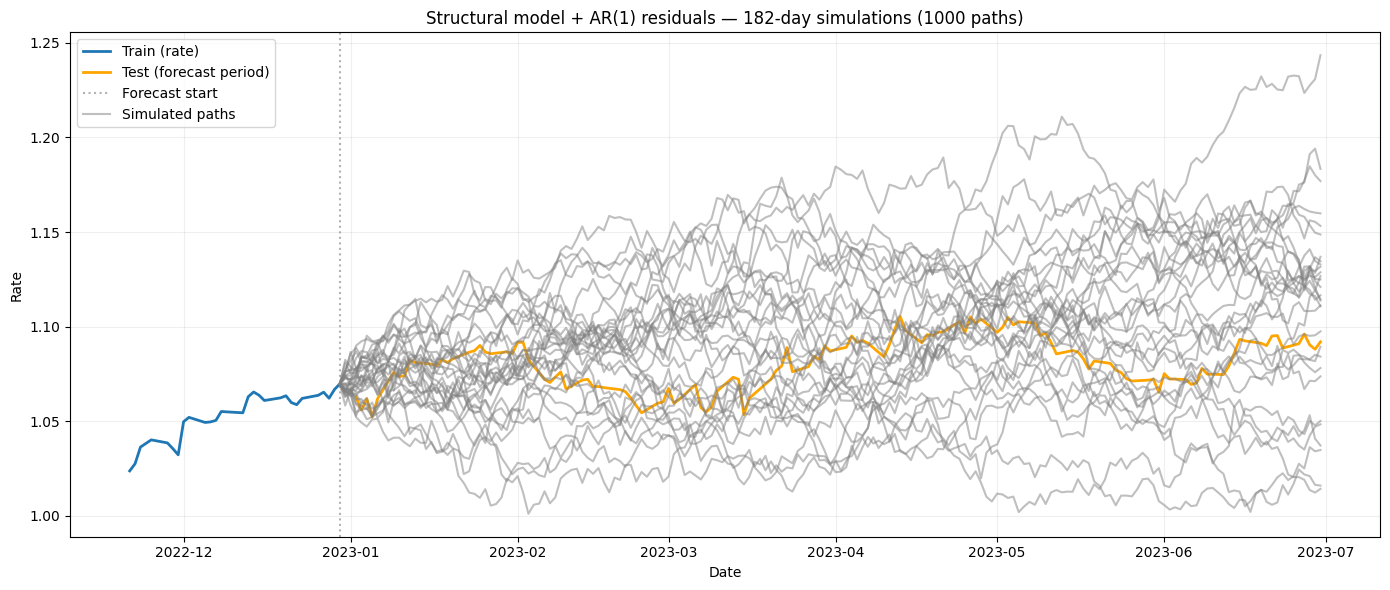

AR(1) params: {'phi': 0.9943272135908586, 'sigma': 0.004943102907961243}
Evaluated dates: 125
Evaluated paths: 1000 of 1000
✅ Expected RMSE (mean over paths): 0.039137
✅ Expected MAE  (mean over paths): 0.032975


In [135]:
# ------------------------
# 6) Prepare exog_future from REAL fundamentals (test window)
# ------------------------
model_name="StructuralModel+AR(1)"
horizon="6M"
steps = 182       

n_sims = 1000          # number of simulation paths
start_fc = last_train_date + pd.Timedelta(days=1)
end_fc   = start_fc + pd.Timedelta(days=steps-1)

exog_future = df_all.loc[start_fc:end_fc, feature_cols].copy()
# exog_future = None # #  to use the last macroeconomic values without updating with future features

# ------------------------
# 7) Run your simulation & evaluation using the aligned df_all and exog_future
# ------------------------
from structural_model import simulate_structural_ar1_paths_and_plot, evaluate_structural_sims

all_paths, det_log, ar1_params = simulate_structural_ar1_paths_and_plot(
    model=model,
    residuals=residuals.loc[df_train.index],
    df=df_all,                     # OK: train + test
    steps=steps,
    n_sims=n_sims,
    n_show=30,
    rate_col=rate_col,
    log_rate_col=y_col,
    feature_cols=tuple(feature_cols),
    exog_future=exog_future,       # real fundamentals in the test period
    use_last_resid=True,
    seed=42,
    test_df=test_df,
    train_end_date=last_train_date 
)

print("AR(1) params:", ar1_params)

# ------------------------
# 8) Evaluate against the test set
# ------------------------
metrics_structural = evaluate_structural_sims(
    all_paths=all_paths,
    test_df=test_df,
    rate_col='rate',        # the column present in test_df
    steps=steps,
    verbose=True
)
# Prepare the summary metrics
summary = append_result(
    summary,
    metrics={
        "rmse(%)": metrics_structural["expected_rmse"]*100,
        "mae(%)":  metrics_structural["expected_mae"]*100
    },
    model_name=model_name,
    horizon=horizon
)


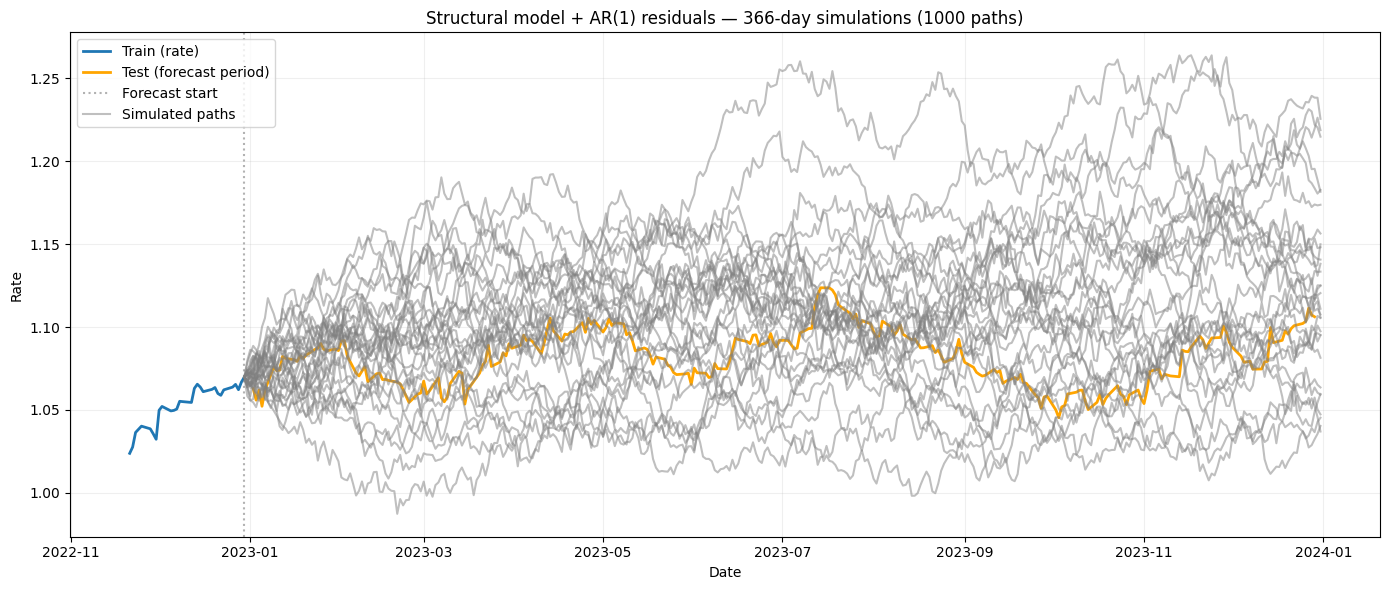

AR(1) params: {'phi': 0.9943272135908586, 'sigma': 0.004943102907961243}
Evaluated dates: 249
Evaluated paths: 1000 of 1000
✅ Expected RMSE (mean over paths): 0.051439
✅ Expected MAE  (mean over paths): 0.042728


In [136]:
# ------------------------
# 6) Prepare exog_future from REAL fundamentals (test window)
# ------------------------
model_name="StructuralModel+AR(1)"
horizon="12M"
steps = 366       

n_sims = 1000          # number of simulation paths
start_fc = last_train_date + pd.Timedelta(days=1)
end_fc   = start_fc + pd.Timedelta(days=steps-1)

exog_future = df_all.loc[start_fc:end_fc, feature_cols].copy()
# exog_future = None # #  to use the last macroeconomic values without updating with future features

# ------------------------
# 7) Run your simulation & evaluation using the aligned df_all and exog_future
# ------------------------
from structural_model import simulate_structural_ar1_paths_and_plot, evaluate_structural_sims

all_paths, det_log, ar1_params = simulate_structural_ar1_paths_and_plot(
    model=model,
    residuals=residuals.loc[df_train.index],
    df=df_all,                     # OK: train + test
    steps=steps,
    n_sims=n_sims,
    n_show=30,
    rate_col=rate_col,
    log_rate_col=y_col,
    feature_cols=tuple(feature_cols),
    exog_future=exog_future,       # real fundamentals in the test period
    use_last_resid=True,
    seed=42,
    test_df=test_df,
    train_end_date=last_train_date 
)

print("AR(1) params:", ar1_params)

# ------------------------
# 8) Evaluate against the test set
# ------------------------
metrics_structural = evaluate_structural_sims(
    all_paths=all_paths,
    test_df=test_df,
    rate_col='rate',        # the column present in test_df
    steps=steps,
    verbose=True
)
# Prepare the summary metrics
summary = append_result(
    summary,
    metrics={
        "rmse(%)": metrics_structural["expected_rmse"]*100,
        "mae(%)":  metrics_structural["expected_mae"]*100
    },
    model_name=model_name,
    horizon=horizon
)


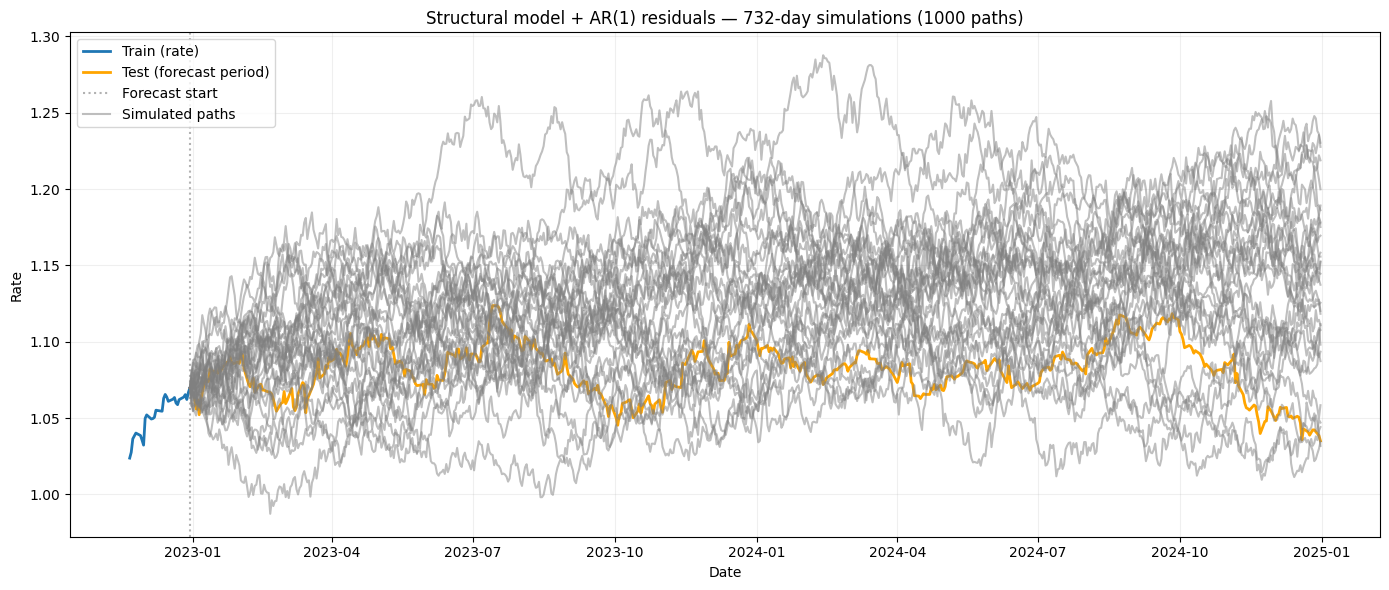

AR(1) params: {'phi': 0.9943272135908586, 'sigma': 0.004943102907961243}
Evaluated dates: 500
Evaluated paths: 1000 of 1000
✅ Expected RMSE (mean over paths): 0.060875
✅ Expected MAE  (mean over paths): 0.050221


In [137]:
# ------------------------
# 6) Prepare exog_future from REAL fundamentals (test window)
# ------------------------
model_name="StructuralModel+AR(1)"
horizon="24M"
steps = 366*2      

n_sims = 1000          # number of simulation paths
start_fc = last_train_date + pd.Timedelta(days=1)
end_fc   = start_fc + pd.Timedelta(days=steps-1)

exog_future = df_all.loc[start_fc:end_fc, feature_cols].copy()
# exog_future = None # #  to use the last macroeconomic values without updating with future features

# ------------------------
# 7) Run your simulation & evaluation using the aligned df_all and exog_future
# ------------------------
from structural_model import simulate_structural_ar1_paths_and_plot, evaluate_structural_sims

all_paths, det_log, ar1_params = simulate_structural_ar1_paths_and_plot(
    model=model,
    residuals=residuals.loc[df_train.index],
    df=df_all,                     # OK: train + test
    steps=steps,
    n_sims=n_sims,
    n_show=30,
    rate_col=rate_col,
    log_rate_col=y_col,
    feature_cols=tuple(feature_cols),
    exog_future=exog_future,       # real fundamentals in the test period
    use_last_resid=True,
    seed=42,
    test_df=test_df,
    train_end_date=last_train_date 
)

print("AR(1) params:", ar1_params)

# ------------------------
# 8) Evaluate against the test set
# ------------------------
metrics_structural = evaluate_structural_sims(
    all_paths=all_paths,
    test_df=test_df,
    rate_col='rate',        # the column present in test_df
    steps=steps,
    verbose=True
)
# Prepare the summary metrics
summary = append_result(
    summary,
    metrics={
        "rmse(%)": metrics_structural["expected_rmse"]*100,
        "mae(%)":  metrics_structural["expected_mae"]*100
    },
    model_name=model_name,
    horizon=horizon
)


In [138]:
summary

model horizon   rmse(%)    mae(%)
0       Discrete Random Walk      1M  1.953220  1.711284
1        Discrete RandomWalk      6M  3.797955  3.238881
2        Discrete RandomWalk     12M  5.282971  4.509970
3        Discrete RandomWalk     24M  7.042312  6.029502
4   Continuous RW with Drift      1M  2.267181  1.977396
5   Continuous RW with Drift      6M  4.788845  4.085394
6   Continuous RW with Drift     12M  6.675744  5.690613
7   Continuous RW with Drift     24M  9.302447  7.942937
8              Continuous RW      1M  2.260765  1.979055
9              Continuous RW      6M  4.858307  4.180052
10             Continuous RW     12M  6.687689  5.717904
11             Continuous RW     24M  9.405833  8.017717
12              Arima(1,1,0)      1M  2.294910  2.006361
13              Arima(1,1,0)      6M  5.032590  4.314017
14              Arima(1,1,0)     12M  7.040806  5.975056
15              Arima(1,1,0)     24M  9.740149  8.322084
16     StructuralModel+AR(1)      1M  2.012924  1.755627
17     StructuralModel+AR(1)      6M  3.913697  3.297497
18     StructuralModel+AR(1)     12M  5.143948  4.272847
19     StructuralModel+AR(1)     24M  6.087528  5.022120

### Structural model + AR+ GARCH

In [139]:
# Structural model (OLS)
# log_rate = β0 + β1 * m_diff + β2 * y_diff + β3 * r_diff + u

# AR(1) for residuals
# u_t =const + ρ u_t−1 + ε_t

# GARCH(1,1) model for ε_t   --> Autoregressive Conditional Heteroskedasticity
# ε_t = σ_t * z_t 
# where z_t ~ N(0,1)
# 𝜎_𝑡 ^2 = 𝜔 + 𝛼 * 𝜀_𝑡−1 ^2 + 𝛽 * 𝜎_𝑡−1 ^2 ​



In [140]:
# eval heteroskedasticity of ε_t using ARCH-LM test
# the variance of errors is not constant, but changes over time depending on its own past.

from statsmodels.stats.diagnostic import het_arch

# ---------- AR(1) to residuals  ----------
residuals = pd.to_numeric(pd.Series(residuals), errors='coerce').dropna()

ar1 = AutoReg(residuals, lags=1, old_names=False).fit()
phi = ar1.params[1]
sigma = float(np.std(ar1.resid, ddof=1))
ar1_params = {'phi': float(phi), 'sigma': float(sigma)}

# eval ε_t after structural + ar(1)
eps = ar1.resid.dropna()        # <--  ε_t
stat, pval, _, _ = het_arch(eps, nlags=10)
print(f"ARCH-LM p-value: {pval:.4f}")

ARCH-LM p-value: 0.0000


#### Forecasting SM + AR(1) + GARCH(1,1,0)

c:\Users\luish\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


AR(1) params: {'phi': 0.9943272135908586, 'const': -5.356894166901158e-05}
GARCH(1,1) params: {'omega': 4.884508332549091e-07, 'alpha': 0.05, 'beta': 0.9299999999999999}
Volatility persistence (alpha+beta): 0.9800


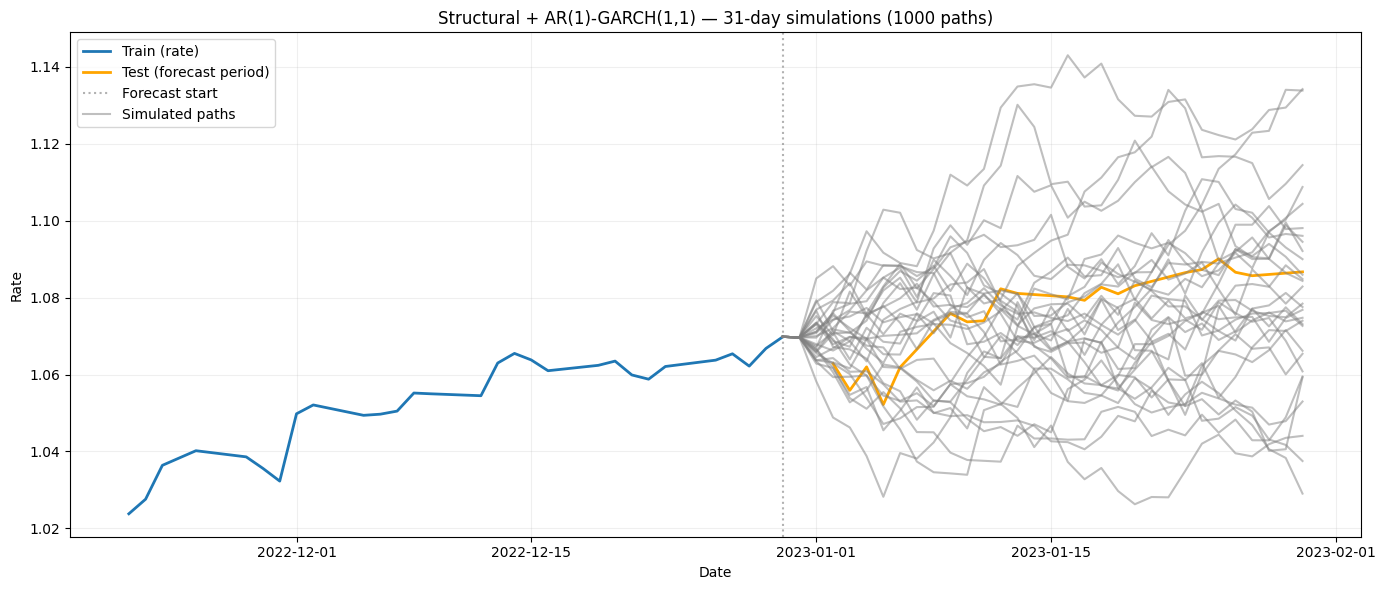

AR(1) params: {'phi': 0.9943272135908586, 'const': -5.356894166901158e-05}
GARCH(1,1) params: {'omega': 4.884508332549091e-07, 'alpha': 0.05, 'beta': 0.9299999999999999}
Evaluated dates: 19
Evaluated paths: 1000 of 1000
✅ Expected RMSE (mean over paths): 0.020305
✅ Expected MAE  (mean over paths): 0.017669


In [141]:
# ------------------------
# 6) Prepare exog_future from REAL fundamentals (test window)
# ------------------------
model_name="StructuralM+AR(1)+GARCH",
horizon="1M"
steps = 31

n_sims = 1000
start_fc = last_train_date + pd.Timedelta(days=1)
end_fc   = start_fc + pd.Timedelta(days=steps-1)

exog_future = df_all.loc[start_fc:end_fc, feature_cols].copy()
# exog_future = None  # to keep last macro values constant

# ------------------------
# 7) Run simulation & evaluation (AR(1)+GARCH)
# ------------------------
from structural_ar_garch_model import (
    simulate_structural_ar1_garch_paths_and_plot,
    evaluate_structural_sims_basic
)

all_paths, det_log, ar1_params, garch_params = simulate_structural_ar1_garch_paths_and_plot(
    model=model,
    residuals=residuals.loc[df_train.index],
    df=df_all,
    steps=steps,
    n_sims=n_sims,
    n_show=30,
    rate_col=rate_col,
    log_rate_col=y_col,
    feature_cols=tuple(feature_cols),
    exog_future=exog_future,
    use_last_resid=True,
    seed=42,
    test_df=test_df,
    train_end_date=last_train_date,
    dist='normal'  # or 't' if you want fat tails
)

print("AR(1) params:", ar1_params)
print("GARCH(1,1) params:", garch_params)

# ------------------------
# 8) Evaluate against the test set
# ------------------------
metrics_structural_garch = evaluate_structural_sims_basic(
    all_paths=all_paths,
    test_df=test_df,
    rate_col='rate',
    steps=steps,
    verbose=True
)

# Append to summary
summary = append_result(
    summary,
    metrics={
        "rmse(%)": metrics_structural_garch["expected_rmse"]*100,
        "mae(%)":  metrics_structural_garch["expected_mae"]*100
    },
    model_name=model_name,
    horizon=horizon
)

c:\Users\luish\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


AR(1) params: {'phi': 0.9943272135908586, 'const': -5.356894166901158e-05}
GARCH(1,1) params: {'omega': 4.884508332549091e-07, 'alpha': 0.05, 'beta': 0.9299999999999999}
Volatility persistence (alpha+beta): 0.9800


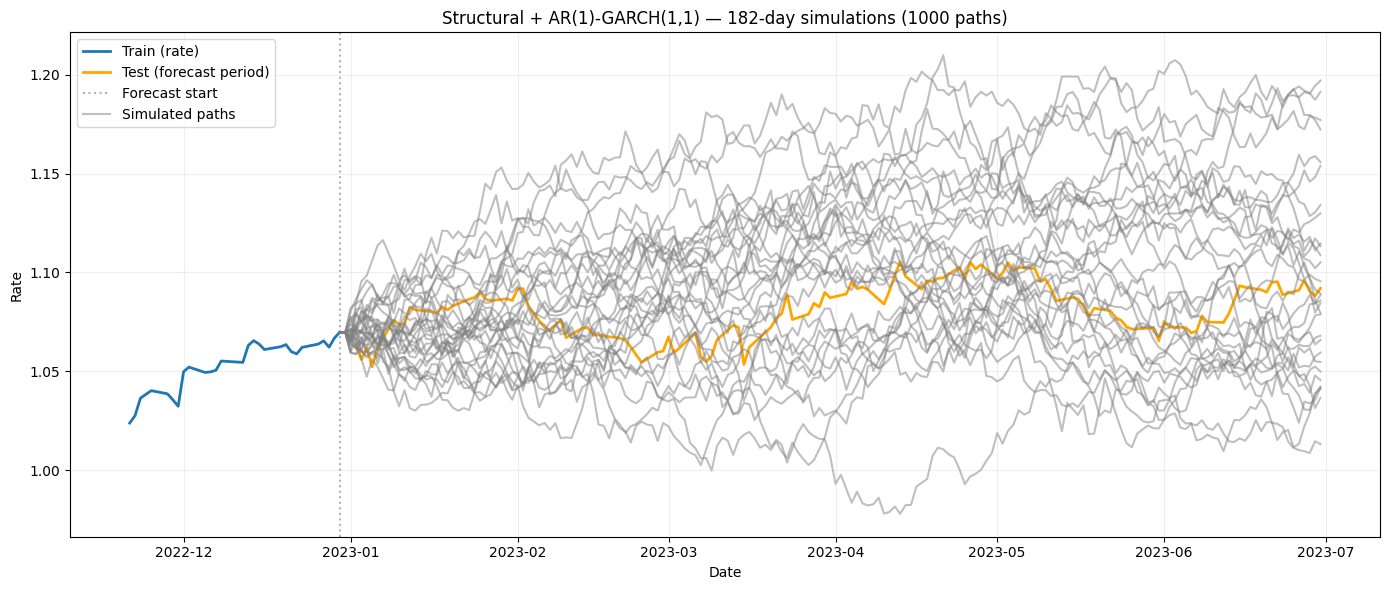

AR(1) params: {'phi': 0.9943272135908586, 'const': -5.356894166901158e-05}
GARCH(1,1) params: {'omega': 4.884508332549091e-07, 'alpha': 0.05, 'beta': 0.9299999999999999}
Evaluated dates: 125
Evaluated paths: 1000 of 1000
✅ Expected RMSE (mean over paths): 0.038307
✅ Expected MAE  (mean over paths): 0.032357


In [142]:
# ------------------------
# 6) Prepare exog_future from REAL fundamentals (test window)
# ------------------------
model_name="StructuralM+AR(1)+GARCH",
horizon="6M"
steps = 182

n_sims = 1000
start_fc = last_train_date + pd.Timedelta(days=1)
end_fc   = start_fc + pd.Timedelta(days=steps-1)

exog_future = df_all.loc[start_fc:end_fc, feature_cols].copy()
# exog_future = None  # to keep last macro values constant

# ------------------------
# 7) Run simulation & evaluation (AR(1)+GARCH)
# ------------------------
from structural_ar_garch_model import (
    simulate_structural_ar1_garch_paths_and_plot,
    evaluate_structural_sims_basic
)

all_paths, det_log, ar1_params, garch_params = simulate_structural_ar1_garch_paths_and_plot(
    model=model,
    residuals=residuals.loc[df_train.index],
    df=df_all,
    steps=steps,
    n_sims=n_sims,
    n_show=30,
    rate_col=rate_col,
    log_rate_col=y_col,
    feature_cols=tuple(feature_cols),
    exog_future=exog_future,
    use_last_resid=True,
    seed=42,
    test_df=test_df,
    train_end_date=last_train_date,
    dist='normal'  # or 't' if you want fat tails
)

print("AR(1) params:", ar1_params)
print("GARCH(1,1) params:", garch_params)

# ------------------------
# 8) Evaluate against the test set
# ------------------------
metrics_structural_garch = evaluate_structural_sims_basic(
    all_paths=all_paths,
    test_df=test_df,
    rate_col='rate',
    steps=steps,
    verbose=True
)

# Append to summary
summary = append_result(
    summary,
    metrics={
        "rmse(%)": metrics_structural_garch["expected_rmse"]*100,
        "mae(%)":  metrics_structural_garch["expected_mae"]*100
    },
    model_name=model_name,
    horizon=horizon
)

c:\Users\luish\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


AR(1) params: {'phi': 0.9943272135908586, 'const': -5.356894166901158e-05}
GARCH(1,1) params: {'omega': 4.884508332549091e-07, 'alpha': 0.05, 'beta': 0.9299999999999999}
Volatility persistence (alpha+beta): 0.9800


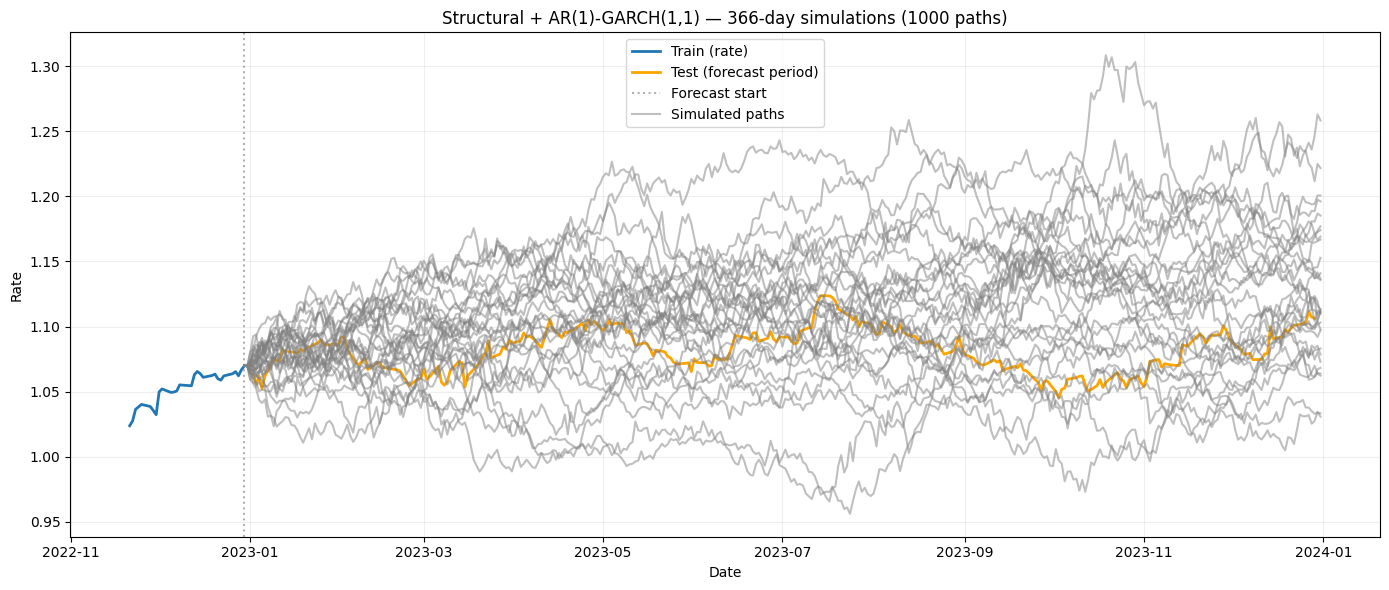

AR(1) params: {'phi': 0.9943272135908586, 'const': -5.356894166901158e-05}
GARCH(1,1) params: {'omega': 4.884508332549091e-07, 'alpha': 0.05, 'beta': 0.9299999999999999}
Evaluated dates: 249
Evaluated paths: 1000 of 1000
✅ Expected RMSE (mean over paths): 0.049639
✅ Expected MAE  (mean over paths): 0.041061


In [143]:
# ------------------------
# 6) Prepare exog_future from REAL fundamentals (test window)
# ------------------------
model_name="StructuralM+AR(1)+GARCH",
horizon="12M"
steps = 366

n_sims = 1000
start_fc = last_train_date + pd.Timedelta(days=1)
end_fc   = start_fc + pd.Timedelta(days=steps-1)

exog_future = df_all.loc[start_fc:end_fc, feature_cols].copy()
# exog_future = None  # to keep last macro values constant

# ------------------------
# 7) Run simulation & evaluation (AR(1)+GARCH)
# ------------------------
from structural_ar_garch_model import (
    simulate_structural_ar1_garch_paths_and_plot,
    evaluate_structural_sims_basic
)

all_paths, det_log, ar1_params, garch_params = simulate_structural_ar1_garch_paths_and_plot(
    model=model,
    residuals=residuals.loc[df_train.index],
    df=df_all,
    steps=steps,
    n_sims=n_sims,
    n_show=30,
    rate_col=rate_col,
    log_rate_col=y_col,
    feature_cols=tuple(feature_cols),
    exog_future=exog_future,
    use_last_resid=True,
    seed=42,
    test_df=test_df,
    train_end_date=last_train_date,
    dist='normal'  # or 't' if you want fat tails
)

print("AR(1) params:", ar1_params)
print("GARCH(1,1) params:", garch_params)

# ------------------------
# 8) Evaluate against the test set
# ------------------------
metrics_structural_garch = evaluate_structural_sims_basic(
    all_paths=all_paths,
    test_df=test_df,
    rate_col='rate',
    steps=steps,
    verbose=True
)

# Append to summary
summary = append_result(
    summary,
    metrics={
        "rmse(%)": metrics_structural_garch["expected_rmse"]*100,
        "mae(%)":  metrics_structural_garch["expected_mae"]*100
    },
    model_name=model_name,
    horizon=horizon
)

c:\Users\luish\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


AR(1) params: {'phi': 0.9943272135908586, 'const': -5.356894166901158e-05}
GARCH(1,1) params: {'omega': 4.884508332549091e-07, 'alpha': 0.05, 'beta': 0.9299999999999999}
Volatility persistence (alpha+beta): 0.9800


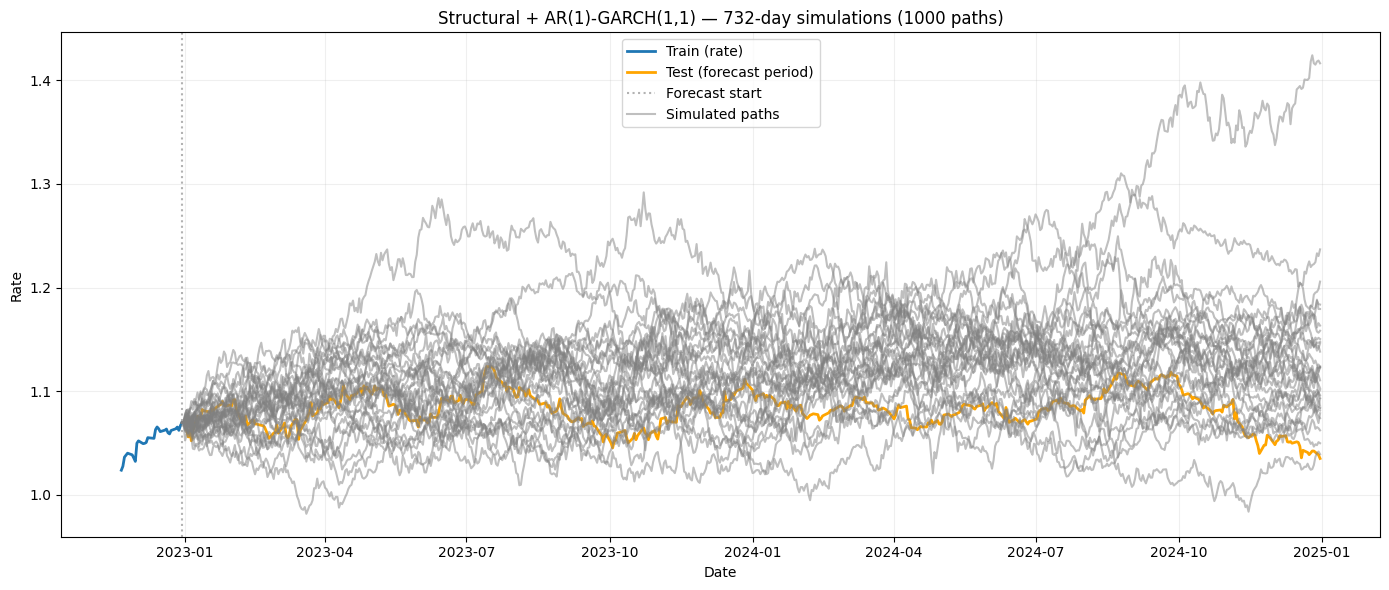

AR(1) params: {'phi': 0.9943272135908586, 'const': -5.356894166901158e-05}
GARCH(1,1) params: {'omega': 4.884508332549091e-07, 'alpha': 0.05, 'beta': 0.9299999999999999}
Evaluated dates: 500
Evaluated paths: 1000 of 1000
✅ Expected RMSE (mean over paths): 0.057182
✅ Expected MAE  (mean over paths): 0.046884


In [144]:
# ------------------------
# 6) Prepare exog_future from REAL fundamentals (test window)
# ------------------------
model_name="StructuralM+AR(1)+GARCH",
horizon="24M"
steps = 366*2

n_sims = 1000
start_fc = last_train_date + pd.Timedelta(days=1)
end_fc   = start_fc + pd.Timedelta(days=steps-1)

exog_future = df_all.loc[start_fc:end_fc, feature_cols].copy()
# exog_future = None  # to keep last macro values constant

# ------------------------
# 7) Run simulation & evaluation (AR(1)+GARCH)
# ------------------------
from structural_ar_garch_model import (
    simulate_structural_ar1_garch_paths_and_plot,
    evaluate_structural_sims_basic
)

all_paths, det_log, ar1_params, garch_params = simulate_structural_ar1_garch_paths_and_plot(
    model=model,
    residuals=residuals.loc[df_train.index],
    df=df_all,
    steps=steps,
    n_sims=n_sims,
    n_show=30,
    rate_col=rate_col,
    log_rate_col=y_col,
    feature_cols=tuple(feature_cols),
    exog_future=exog_future,
    use_last_resid=True,
    seed=42,
    test_df=test_df,
    train_end_date=last_train_date,
    dist='normal'  # or 't' if you want fat tails
)

print("AR(1) params:", ar1_params)
print("GARCH(1,1) params:", garch_params)

# ------------------------
# 8) Evaluate against the test set
# ------------------------
metrics_structural_garch = evaluate_structural_sims_basic(
    all_paths=all_paths,
    test_df=test_df,
    rate_col='rate',
    steps=steps,
    verbose=True
)

# Append to summary
summary = append_result(
    summary,
    metrics={
        "rmse(%)": metrics_structural_garch["expected_rmse"]*100,
        "mae(%)":  metrics_structural_garch["expected_mae"]*100
    },
    model_name=model_name,
    horizon=horizon
)

In [145]:
summary

model horizon   rmse(%)    mae(%)
0         Discrete Random Walk      1M  1.953220  1.711284
1          Discrete RandomWalk      6M  3.797955  3.238881
2          Discrete RandomWalk     12M  5.282971  4.509970
3          Discrete RandomWalk     24M  7.042312  6.029502
4     Continuous RW with Drift      1M  2.267181  1.977396
5     Continuous RW with Drift      6M  4.788845  4.085394
6     Continuous RW with Drift     12M  6.675744  5.690613
7     Continuous RW with Drift     24M  9.302447  7.942937
8                Continuous RW      1M  2.260765  1.979055
9                Continuous RW      6M  4.858307  4.180052
10               Continuous RW     12M  6.687689  5.717904
11               Continuous RW     24M  9.405833  8.017717
12                Arima(1,1,0)      1M  2.294910  2.006361
13                Arima(1,1,0)      6M  5.032590  4.314017
14                Arima(1,1,0)     12M  7.040806  5.975056
15                Arima(1,1,0)     24M  9.740149  8.322084
16       StructuralModel+AR(1)      1M  2.012924  1.755627
17       StructuralModel+AR(1)      6M  3.913697  3.297497
18       StructuralModel+AR(1)     12M  5.143948  4.272847
19       StructuralModel+AR(1)     24M  6.087528  5.022120
20  (StructuralM+AR(1)+GARCH,)      1M  2.030521  1.766858
21  (StructuralM+AR(1)+GARCH,)      6M  3.830693  3.235693
22  (StructuralM+AR(1)+GARCH,)     12M  4.963946  4.106098
23  (StructuralM+AR(1)+GARCH,)     24M  5.718184  4.688403

## DEX US SF

In [216]:
# Read the CSV file from the preprocessing folder
train_df = pd.read_csv('../2. preprocesing/train_df_dexussf.csv', index_col=0, parse_dates=True)

# Show the first rows
train_df.head()

rate  rate_interpolated  log_rate      diff        Wt
date                                                                 
2015-01-05  0.085357           0.085357 -2.460913 -0.001409 -0.001226
2015-01-06  0.085466           0.085466 -2.459632  0.001281  0.001465
2015-01-07  0.085415           0.085415 -2.460230 -0.000598 -0.000415
2015-01-08  0.086558           0.086558 -2.446945  0.013285  0.013468
2015-01-09  0.087070           0.087070 -2.441042  0.005903  0.006087

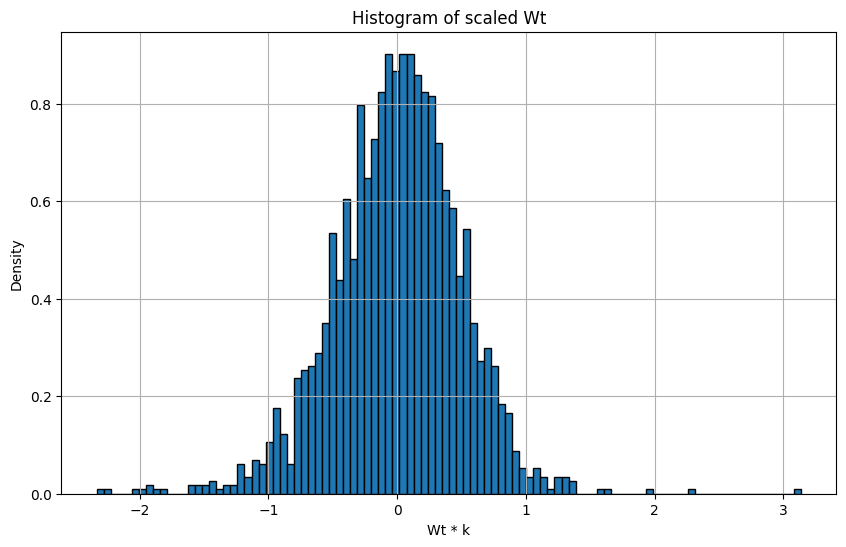

count    2085.000000
mean        0.000004
std         0.009860
min        -0.046718
25%        -0.005882
50%         0.000361
75%         0.006290
max         0.062758
Name: Wt, dtype: float64


In [217]:
k = 50
df= train_df.copy()
df['scaled_Wt'] = df['Wt'] * k
# basic histogram of the scaled Wt
plt.figure(figsize=(10,6))
plt.hist(df['scaled_Wt'], bins=100, edgecolor='black', density=True)
plt.title('Histogram of scaled Wt')
plt.xlabel('Wt * k')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# statistics of the original Wt
print(df['Wt'].describe())

Empirical probabilities:
P(-1) = 0.1405, P(0) = 0.7185, P(+1) = 0.1410


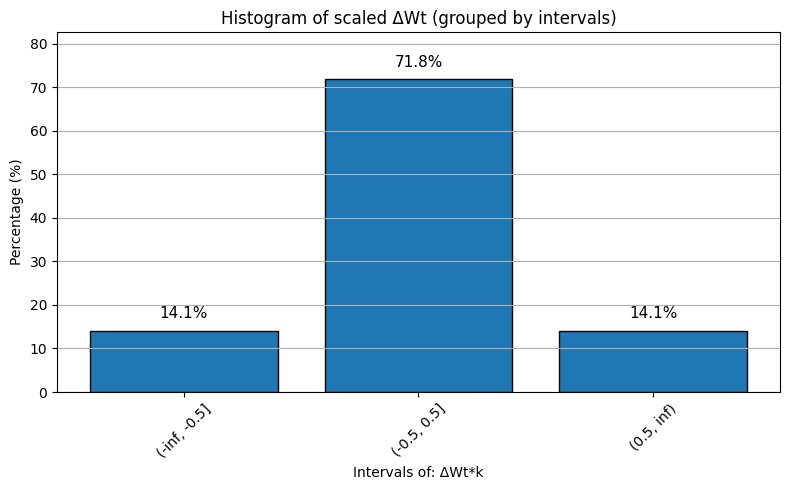

rate  rate_interpolated  log_rate      diff        Wt  \
date                                                                    
2015-01-05  0.085357           0.085357 -2.460913 -0.001409 -0.001226   
2015-01-06  0.085466           0.085466 -2.459632  0.001281  0.001465   
2015-01-07  0.085415           0.085415 -2.460230 -0.000598 -0.000415   
2015-01-08  0.086558           0.086558 -2.446945  0.013285  0.013468   
2015-01-09  0.087070           0.087070 -2.441042  0.005903  0.006087   
...              ...                ...       ...       ...       ...   
2022-12-26       NaN           0.058356 -2.841191 -0.009596 -0.009413   
2022-12-27  0.057793           0.057793 -2.850880 -0.009689 -0.009506   
2022-12-28  0.058428           0.058428 -2.839955  0.010925  0.011108   
2022-12-29  0.059207           0.059207 -2.826722  0.013234  0.013417   
2022-12-30  0.058841           0.058841 -2.832919 -0.006197 -0.006014   

            scaled_Wt  e_t scaled_Wt_bin  
date                                      
2015-01-05  -0.061291    0   (-0.5, 0.5]  
2015-01-06   0.073237    0   (-0.5, 0.5]  
2015-01-07  -0.020726    0   (-0.5, 0.5]  
2015-01-08   0.673404    1    (0.5, inf)  
2015-01-09   0.304344    0   (-0.5, 0.5]  
...               ...  ...           ...  
2022-12-26  -0.470635    0   (-0.5, 0.5]  
2022-12-27  -0.475284    0   (-0.5, 0.5]  
2022-12-28   0.555410    1    (0.5, inf)  
2022-12-29   0.670855    1    (0.5, inf)  
2022-12-30  -0.300694    0   (-0.5, 0.5]  

[2085 rows x 8 columns]

In [218]:
# Step 1: Discretise Wt and get probabilities
train_df_dexuseu, p_dict = discretise_Wt(train_df, k=k)

train_df_dexuseu

## DEX US PEN

In [219]:
# Read the CSV file from the preprocessing folder
train_df = pd.read_csv('../2. preprocesing/train_df_usdpen.csv', index_col=0, parse_dates=True)

# Show the first rows
train_df.head()

rate  rate_interpolated  log_rate      diff        Wt
date                                                                 
2015-01-06  0.335233           0.335233 -1.092930  0.003013  0.003101
2015-01-07  0.334784           0.334784 -1.094270 -0.001340 -0.001251
2015-01-08  0.334560           0.334560 -1.094939 -0.000669 -0.000581
2015-01-09  0.334896           0.334896 -1.093935  0.001004  0.001093
2015-01-12  0.334560           0.334560 -1.094939 -0.001004 -0.000915

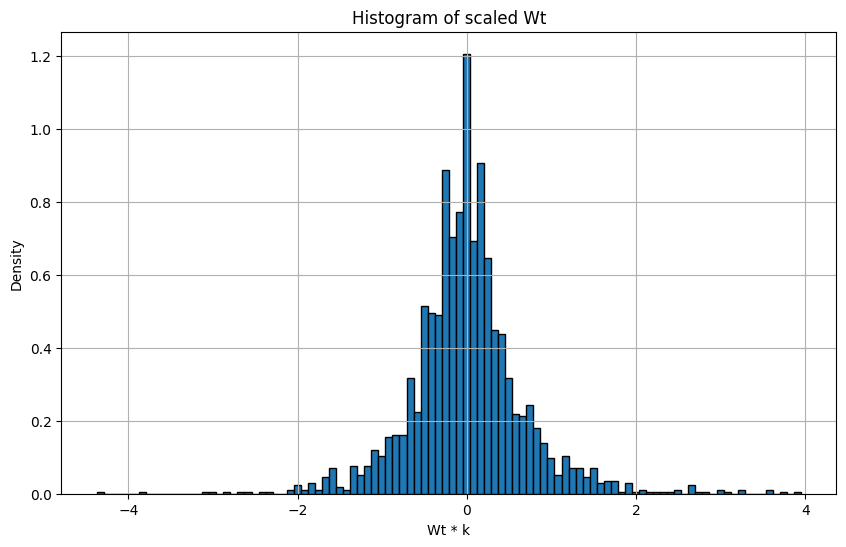

count    2084.000000
mean       -0.000029
std         0.003457
min        -0.021879
25%        -0.001695
50%        -0.000196
75%         0.001391
max         0.019738
Name: Wt, dtype: float64


In [220]:
k = 200
df= train_df.copy()
df['scaled_Wt'] = df['Wt'] * k
# basic histogram of the scaled Wt
plt.figure(figsize=(10,6))
plt.hist(df['scaled_Wt'], bins=100, edgecolor='black', density=True)
plt.title('Histogram of scaled Wt')
plt.xlabel('Wt * k')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# statistics of the original Wt
print(df['Wt'].describe())

Empirical probabilities:
P(-1) = 0.1703, P(0) = 0.6761, P(+1) = 0.1536


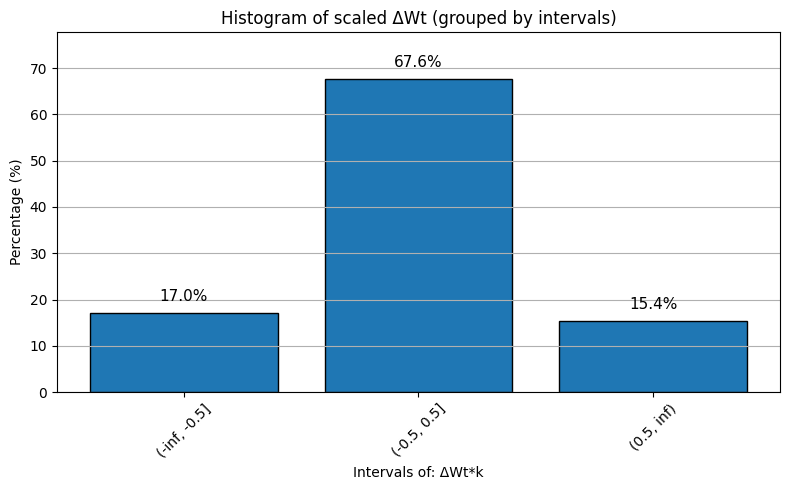

rate  rate_interpolated  log_rate      diff        Wt  \
date                                                                    
2015-01-06  0.335233           0.335233 -1.092930  0.003013  0.003101   
2015-01-07  0.334784           0.334784 -1.094270 -0.001340 -0.001251   
2015-01-08  0.334560           0.334560 -1.094939 -0.000669 -0.000581   
2015-01-09  0.334896           0.334896 -1.093935  0.001004  0.001093   
2015-01-12  0.334560           0.334560 -1.094939 -0.001004 -0.000915   
...              ...                ...       ...       ...       ...   
2022-12-26  0.261575           0.261575 -1.341035  0.001046  0.001134   
2022-12-27  0.261643           0.261643 -1.340774  0.000262  0.000350   
2022-12-28  0.261986           0.261986 -1.339465  0.001309  0.001398   
2022-12-29  0.261917           0.261917 -1.339727 -0.000262 -0.000173   
2022-12-30  0.261780           0.261780 -1.340250 -0.000524 -0.000435   

            scaled_Wt  e_t scaled_Wt_bin  
date                                      
2015-01-06   0.620249    1    (0.5, inf)  
2015-01-07  -0.250268    0   (-0.5, 0.5]  
2015-01-08  -0.116130    0   (-0.5, 0.5]  
2015-01-09   0.218575    0   (-0.5, 0.5]  
2015-01-12  -0.183098    0   (-0.5, 0.5]  
...               ...  ...           ...  
2022-12-26   0.226889    0   (-0.5, 0.5]  
2022-12-27   0.070060    0   (-0.5, 0.5]  
2022-12-28   0.279553    0   (-0.5, 0.5]  
2022-12-29  -0.034652    0   (-0.5, 0.5]  
2022-12-30  -0.087001    0   (-0.5, 0.5]  

[2084 rows x 8 columns]

In [221]:
# Step 1: Discretise Wt and get probabilities
train_df_dexuseu, p_dict = discretise_Wt(train_df, k=k)

train_df_dexuseu